In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
%matplotlib inline
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision

import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
y = np.random.randint(0,3,150)
idx= []
for i in range(3):
    print(i,sum(y==i))
    idx.append(y==i)

0 54
1 54
2 42


In [3]:
x = np.zeros((150,))
# x1 = np.zeros((500,2))

In [4]:
x[idx[0]] = np.random.uniform(low =-1,high =0,size= sum(idx[0]))
x[idx[1]] = np.random.uniform(low =0,high =1,size= sum(idx[1]))
x[idx[2]] = np.random.uniform(low =2,high =3,size= sum(idx[2]))
# x[idx[3],:] = np.random.normal(loc = 3)

In [5]:
x.shape,y.shape

((150,), (150,))

In [6]:
idx= []
for i in range(3):
    #print(i,sum(y==i))
    idx.append(y==i)

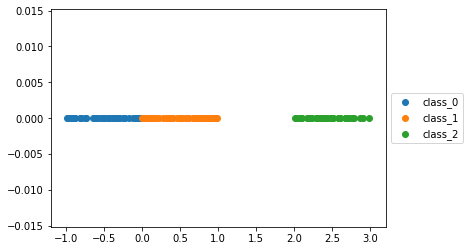

In [7]:
for i in range(3):
    y= np.zeros(x[idx[i]].shape[0])
    plt.scatter(x[idx[i]],y,label="class_"+str(i))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [8]:
foreground_classes = {'class_0','class_1'}

background_classes = {'class_2'}

In [9]:
fg_class  = np.random.randint(0,2)
fg_idx = np.random.randint(0,2)

a = []
for i in range(2):
    if i == fg_idx:
        b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
        a.append(x[b])
        print("foreground "+str(fg_class)+" present at " + str(fg_idx))
    else:
        bg_class = np.random.randint(2,3)
        b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
        a.append(x[b])
        print("background "+str(bg_class)+" present at " + str(i))
a = np.concatenate(a,axis=0)
#print(a.shape)

print(fg_class , fg_idx)

background 2 present at 0
foreground 0 present at 1
0 1


In [10]:
desired_num = 1000
mosaic_list =[]
mosaic_label = []
fore_idx=[]
for j in range(desired_num):
    fg_class  = np.random.randint(0,2)
    fg_idx = np.random.randint(0,1)
    a = []
    for i in range(2):
        if i == fg_idx:
            b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
            a.append(x[b])
#             print("foreground "+str(fg_class)+" present at " + str(fg_idx))
        else:
            bg_class = np.random.randint(2,3)
            b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
            a.append(x[b])
#             print("background "+str(bg_class)+" present at " + str(i))
    a = np.concatenate(a,axis=0)
    mosaic_list.append(np.reshape(a,(2,1)))
    mosaic_label.append(fg_class)
    fore_idx.append(fg_idx)

In [11]:
mosaic_list = np.concatenate(mosaic_list,axis=1).T
print(mosaic_list)

[[ 0.40244976  2.72925202]
 [-0.32410954  2.19908874]
 [ 0.03601749  2.01461906]
 ...
 [ 0.5171965   2.28929146]
 [ 0.9768467   2.98859603]
 [ 0.5171965   2.87122565]]


In [12]:
print(np.shape(mosaic_label))
print(np.shape(fore_idx))

(1000,)
(1000,)


In [13]:
class MosaicDataset(Dataset):
    """MosaicDataset dataset."""
    
    
    def __init__(self, mosaic_list, mosaic_label, fore_idx):
        """
          Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.mosaic = mosaic_list
        self.label = mosaic_label
        self.fore_idx = fore_idx

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        return self.mosaic[idx] , self.label[idx], self.fore_idx[idx]

batch = 250
msd = MosaicDataset(mosaic_list, mosaic_label , fore_idx)
train_loader = DataLoader( msd,batch_size= batch ,shuffle=False)

In [14]:
class Wherenet(nn.Module):
    def __init__(self):
        super(Wherenet,self).__init__()
        self.linear1 = nn.Linear(1,1)

    def forward(self,z):
        x = torch.zeros([batch,2],dtype=torch.float64)
        y = torch.zeros([batch], dtype=torch.float64)
        #x,y = x.to("cuda"),y.to("cuda")
        for i in range(2):
            x[:,i] = self.helper(z[:,i])[:,0]
            #print(k[:,0].shape,x[:,i].shape)
        x = F.softmax(x,dim=1)   # alphas
        
        #print("after network",x.shape)
        x1 = x[:,0]
        #print("alphas before",y.shape)
        for i in range(2):
            x1 = x[:,i]          
            #print(torch.mul(x1,z[:,i]).shape)
            y = y+torch.mul(x1,z[:,i])
            #print("alphas",y.shape)
        #print(y[0])
        return y[:,None] , x 

    
    def helper(self,x):
        #print(x.shape)
        x = self.linear1(x[:,None])
#         x = F.relu(self.linear2(x))
#         x = self.linear3(x)
        return x

    

In [15]:
trainiter = iter(train_loader)
input1,labels1,index1 = trainiter.next()



In [16]:
where = Wherenet().double()
where = where
out_avg,alphas = where(input1)
#out_where.shape,alphas.shape

In [17]:
out_avg.shape,alphas.shape

(torch.Size([250, 1]), torch.Size([250, 2]))

In [18]:
class Whatnet(nn.Module):
    def __init__(self):
        super(Whatnet,self).__init__()
        self.linear1 = nn.Linear(1,2)
#         self.linear2 = nn.Linear(8,16)
#         self.linear3 = nn.Linear(16,3)
    def forward(self,x):
        x = self.linear1(x)
#         x = F.relu(self.linear2(x))
#         x = self.linear3(x)
        return x

In [19]:
what =Whatnet().double()
what(out_avg)

tensor([[-0.3187, -2.8851],
        [-0.1402, -2.4417],
        [-0.0630, -2.2501],
        [-0.2576, -2.7334],
        [-0.0630, -2.2501],
        [-0.3844, -3.0484],
        [-0.1600, -2.4911],
        [-0.1816, -2.5446],
        [-0.3191, -2.8861],
        [-0.2413, -2.6930],
        [-0.1550, -2.4787],
        [-0.3142, -2.8740],
        [-0.2256, -2.6541],
        [-0.2232, -2.6481],
        [-0.2231, -2.6477],
        [-0.3164, -2.8796],
        [-0.3224, -2.8945],
        [-0.0971, -2.3348],
        [-0.2547, -2.7262],
        [-0.2340, -2.6749],
        [-0.1961, -2.5808],
        [-0.1945, -2.5767],
        [-0.2253, -2.6532],
        [-0.2323, -2.6706],
        [-0.4383, -3.1823],
        [-0.1009, -2.3442],
        [-0.1384, -2.4374],
        [-0.3803, -3.0381],
        [-0.1729, -2.5232],
        [-0.1626, -2.4974],
        [-0.4040, -3.0970],
        [-0.1191, -2.3894],
        [-0.3373, -2.9315],
        [-0.3350, -2.9258],
        [-0.4025, -3.0932],
        [-0.1822, -2

In [20]:
for w in what.parameters():
    print(w)

Parameter containing:
tensor([[-0.3473],
        [-0.8626]], dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([ 0.5134, -0.8183], dtype=torch.float64, requires_grad=True)


In [21]:
for w in where.parameters():
    print(w)

Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)


In [22]:
def fixed_what_init(m):
    if isinstance(m,nn.Linear):
        size = m.weight.size()
        fan_out = size[0] # number of rows
        fan_in = size[1] # number of columns
        print("before",m.weight.data,"bias",m.bias.data)
        m.weight.data = -torch.ones(size,dtype = torch.float64)*2
        #m.weight.data[0,0] = -1
        m.bias.data = torch.zeros(fan_out,dtype= torch.float64)
        print("after",m.weight.data,"bias",m.bias.data)


In [23]:
what.apply(fixed_what_init)

before tensor([[-0.3473],
        [-0.8626]], dtype=torch.float64) bias tensor([ 0.5134, -0.8183], dtype=torch.float64)
after tensor([[-2.],
        [-2.]], dtype=torch.float64) bias tensor([0., 0.], dtype=torch.float64)


Whatnet(
  (linear1): Linear(in_features=1, out_features=2, bias=True)
)

In [24]:
def fixed_where_init(m):
    if isinstance(m,nn.Linear):
        size = m.weight.size()
        fan_out = size[0] # number of rows
        fan_in = size[1] # number of columns
        print("before",m.weight.data,"bias",m.bias.data)
        m.weight.data = -torch.ones((1,1),dtype = torch.float64)*0.5
        m.bias.data = torch.zeros((1),dtype= torch.float64)
        print("after",m.weight.data,"bias",m.bias.data)


In [25]:
# where.apply(fixed_where_init)

In [26]:
def disp_plot(data,avg_data,i,true_label,pred_label,alpha,true_idx):
    plt.figure(figsize=(6,6))
    data = data.numpy()
    alpha = alpha.detach().numpy()
    avg_data = avg_data.detach().numpy()
    x = data[:,0] 
    y = data[:,1]

    x1 =np.arange(0,10,1)
    for i in range(0,10):
        plt.plot([x[i],y[i]],[x1[i],x1[i]],'ro-')
        plt.scatter(avg_data[i],x1[i],marker="X",linewidths=10)


new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
[1,     4] loss: 0.693
[1,    4] accuracy: 0.506
new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
new_we

new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
[12,     4] loss: 0.693
[12,    4] accuracy: 0.506
new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
new_

/home/dell/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
[22,     4] loss: 0.693
[22,    4] accuracy: 0.506
new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
new_

new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
[37,     4] loss: 0.693
[37,    4] accuracy: 0.506
new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
new_

new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
[51,     4] loss: 0.693
[51,    4] accuracy: 0.506
new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
new_

new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
[65,     4] loss: 0.693
[65,    4] accuracy: 0.506
new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
new_

new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
[79,     4] loss: 0.693
[79,    4] accuracy: 0.506
new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
new_

new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
[94,     4] loss: 0.693
[94,    4] accuracy: 0.506
new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
new_

new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
[108,     4] loss: 0.693
[108,    4] accuracy: 0.506
new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
ne

new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
[122,     4] loss: 0.693
[122,    4] accuracy: 0.506
new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
ne

new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
[137,     4] loss: 0.693
[137,    4] accuracy: 0.506
new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
ne

new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
[150,     4] loss: 0.693
[150,    4] accuracy: 0.506
new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
ne

new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
[165,     4] loss: 0.693
[165,    4] accuracy: 0.506
new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
ne

new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
[178,     4] loss: 0.693
[178,    4] accuracy: 0.506
new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
[1

new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
[190,     4] loss: 0.693
[190,    4] accuracy: 0.506
new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
ne

new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
[205,     4] loss: 0.693
[205,    4] accuracy: 0.506
new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
ne

new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
[220,     4] loss: 0.693
[220,    4] accuracy: 0.506
new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
ne

new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
[230,     4] loss: 0.693
[230,    4] accuracy: 0.506
new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
ne

new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
[243,     4] loss: 0.693
[243,    4] accuracy: 0.506
new_weights  Parameter containing:
tensor([[0.7689]], dtype=torch.float64, requires_grad=True)
new_weights  Parameter containing:
tensor([-0.7184], dtype=torch.float64, requires_grad=True)
ne

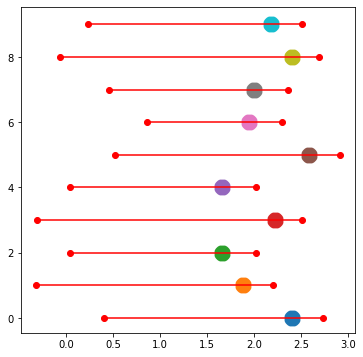

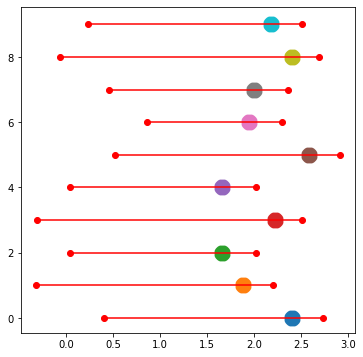

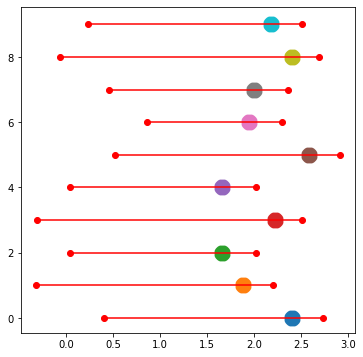

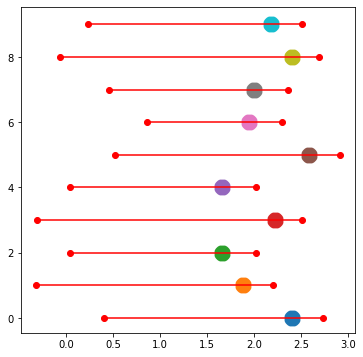

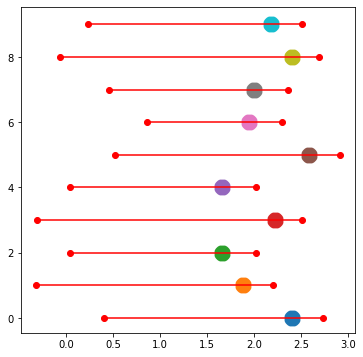

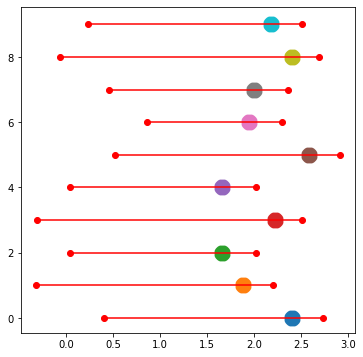

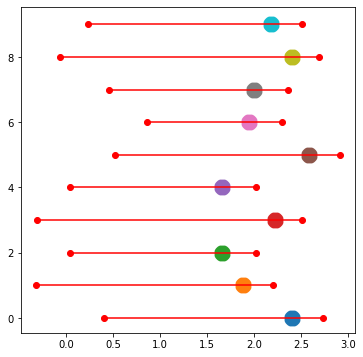

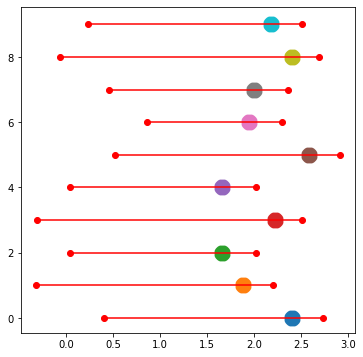

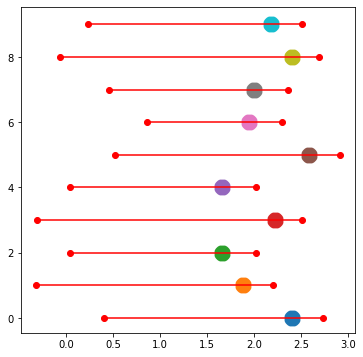

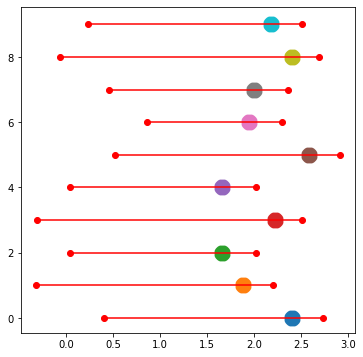

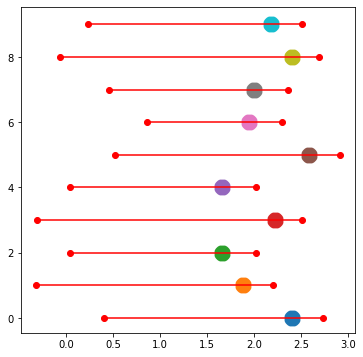

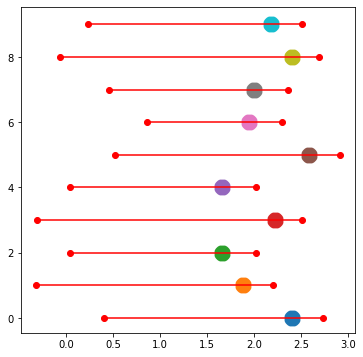

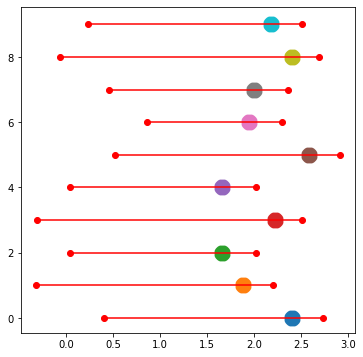

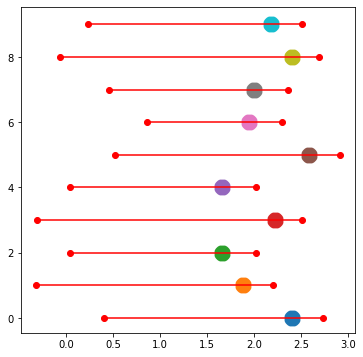

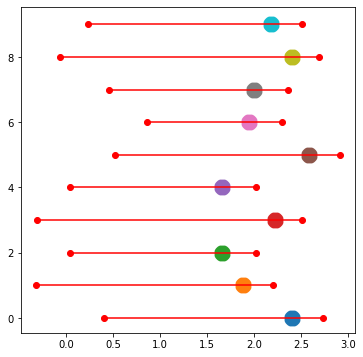

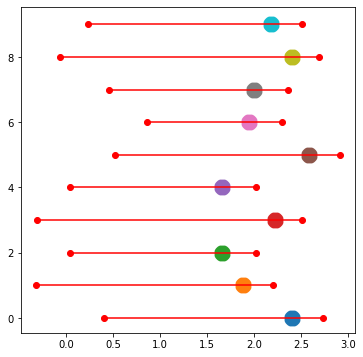

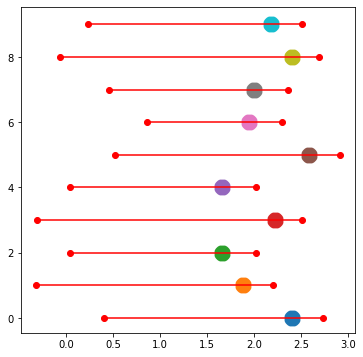

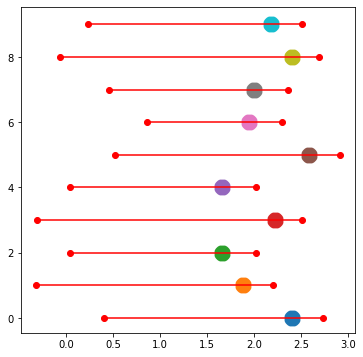

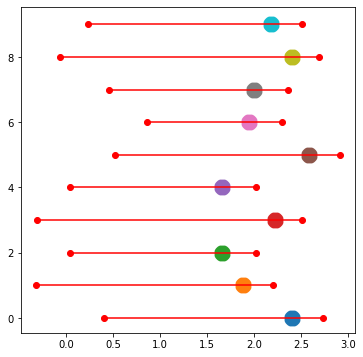

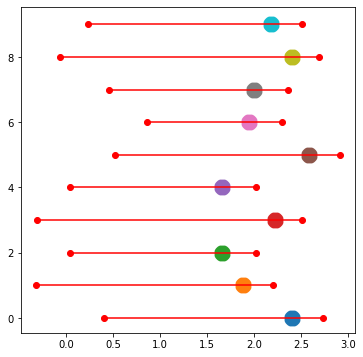

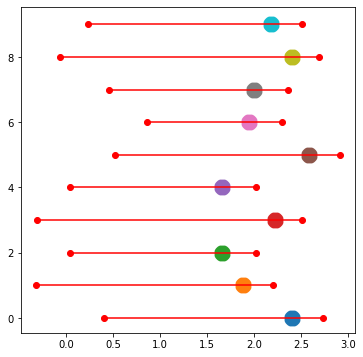

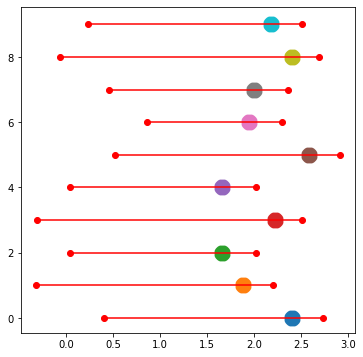

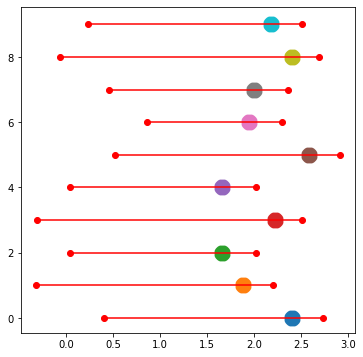

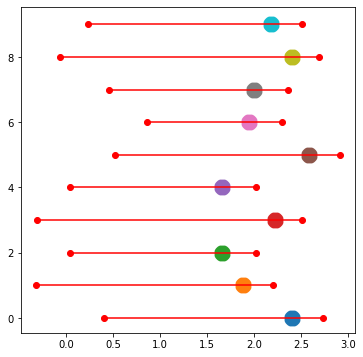

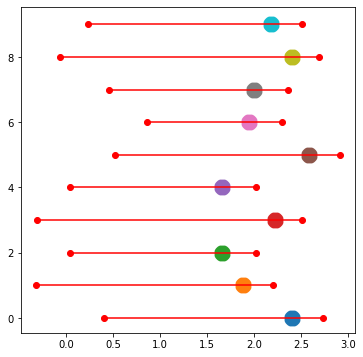

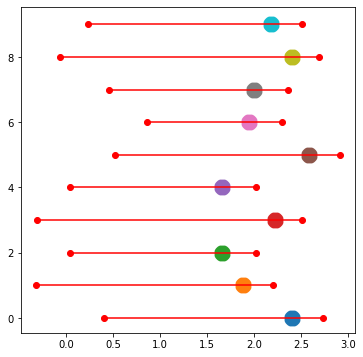

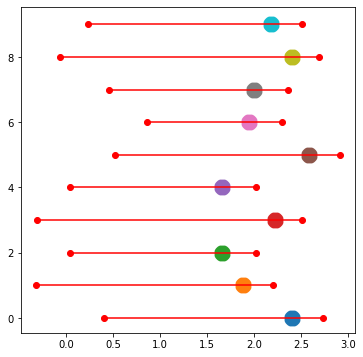

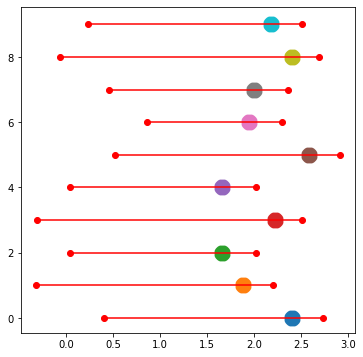

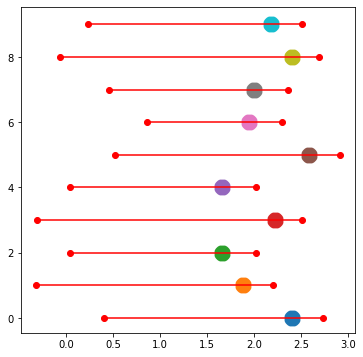

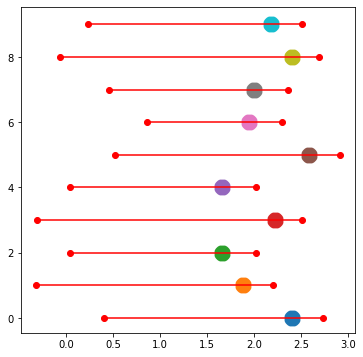

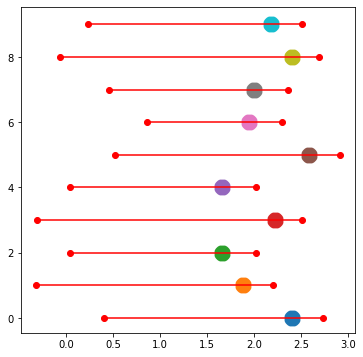

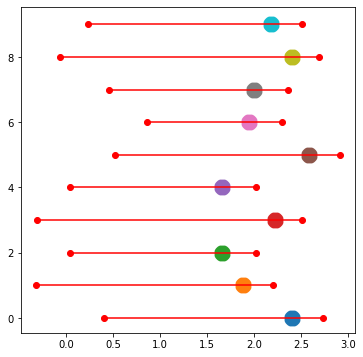

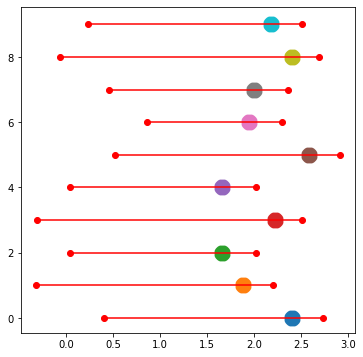

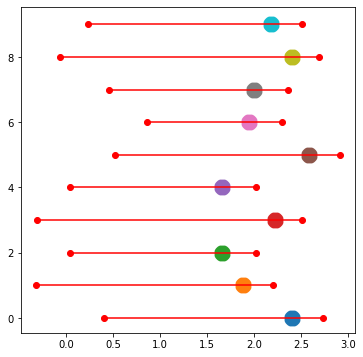

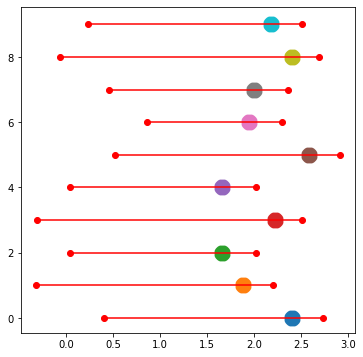

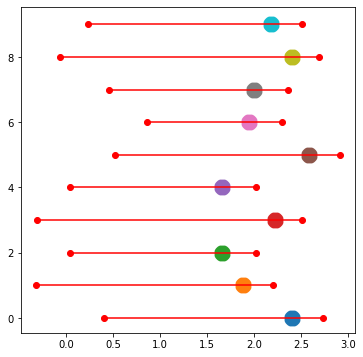

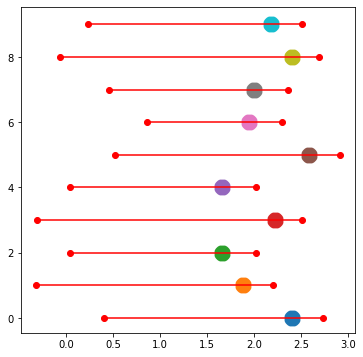

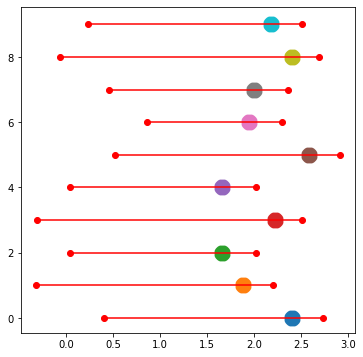

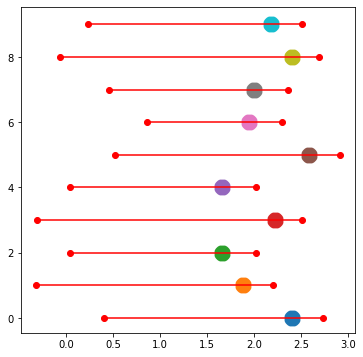

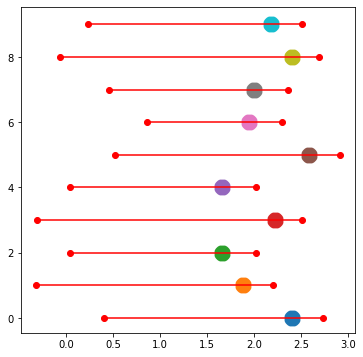

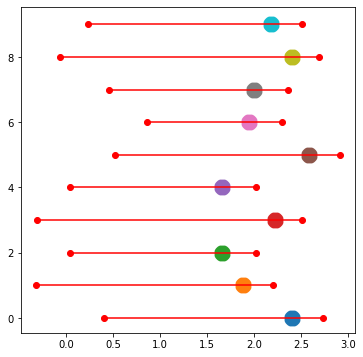

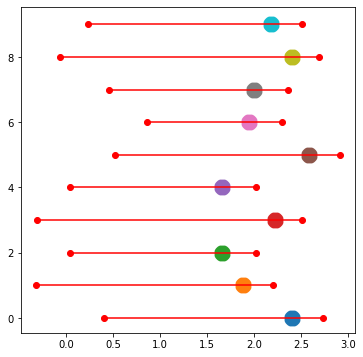

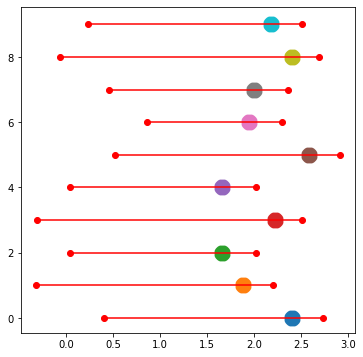

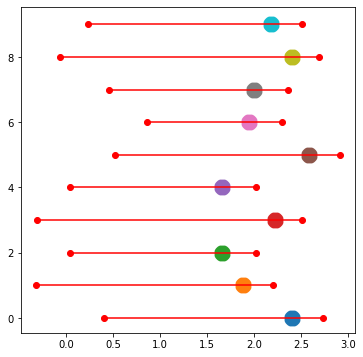

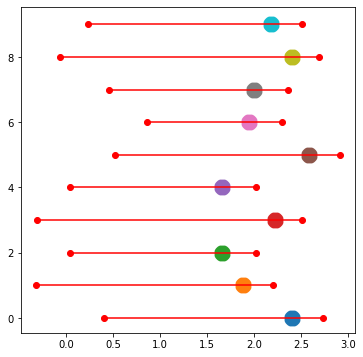

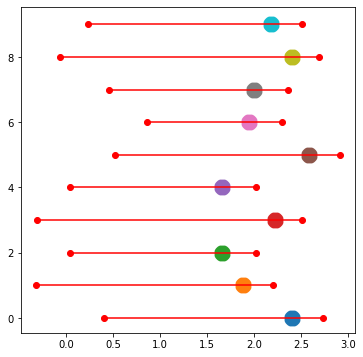

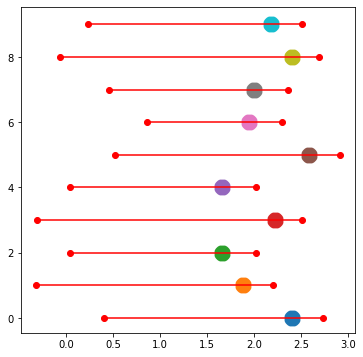

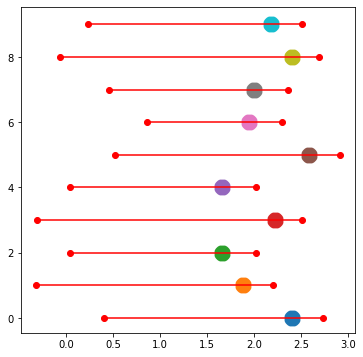

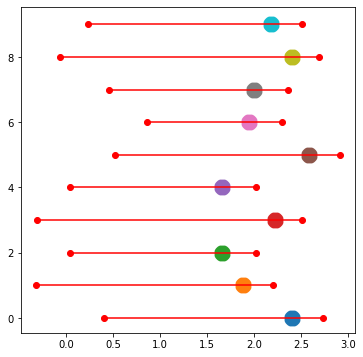

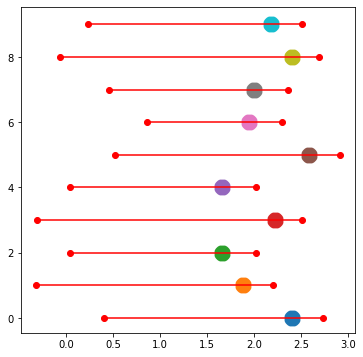

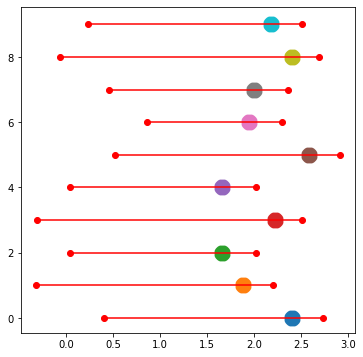

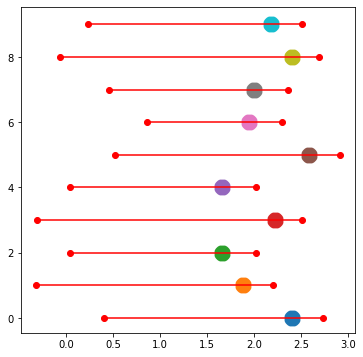

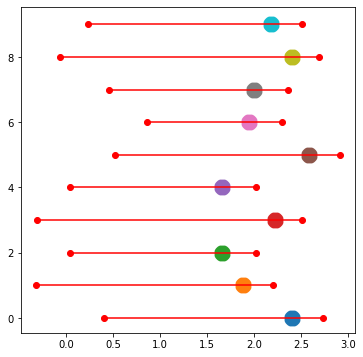

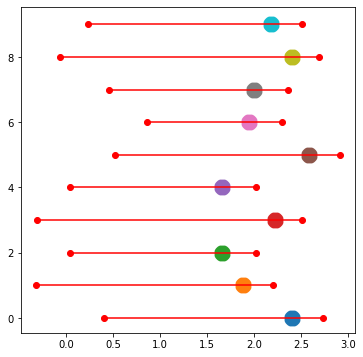

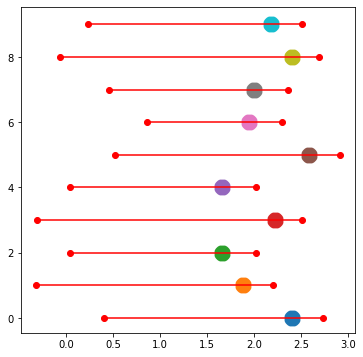

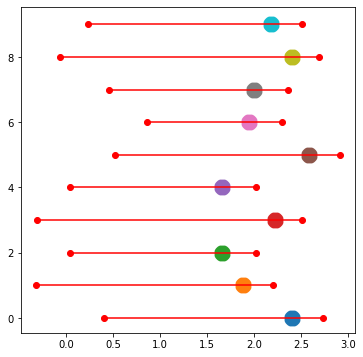

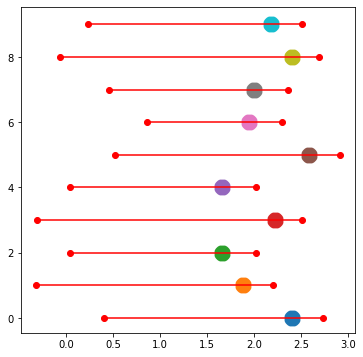

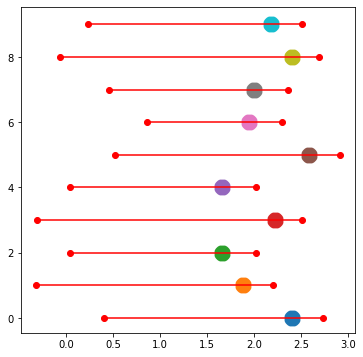

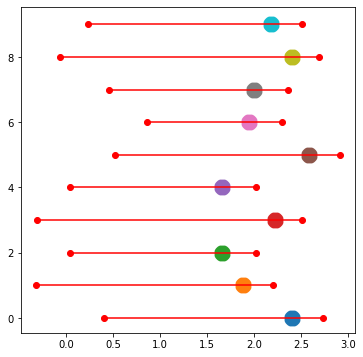

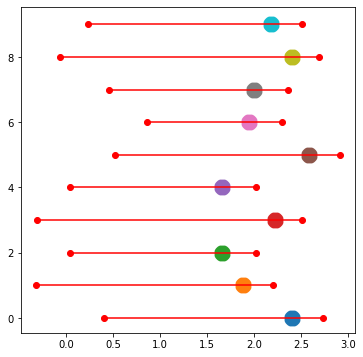

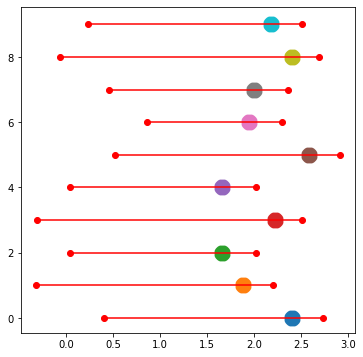

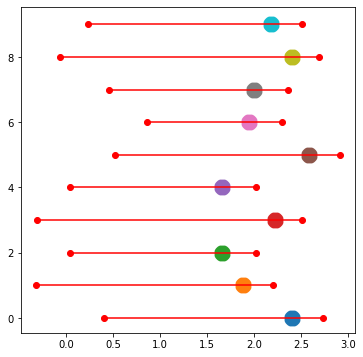

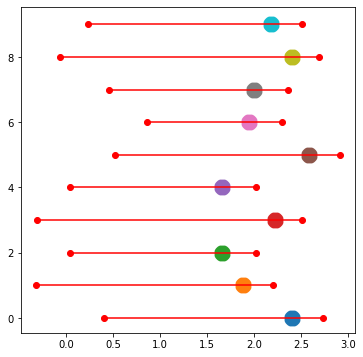

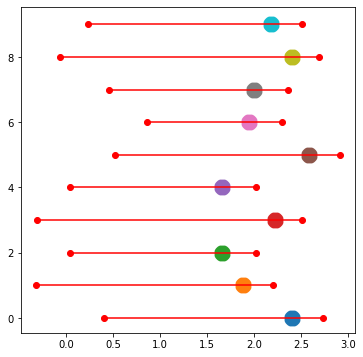

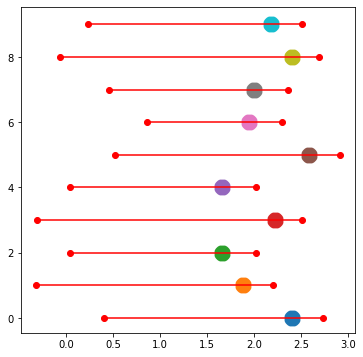

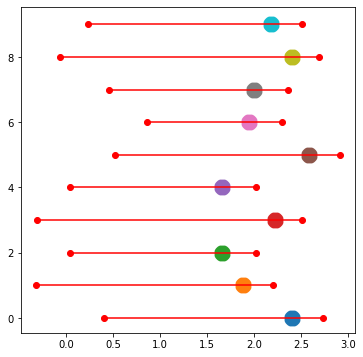

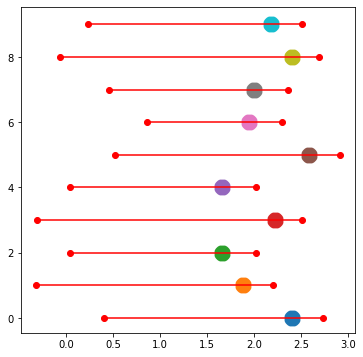

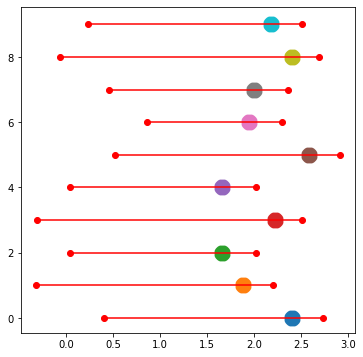

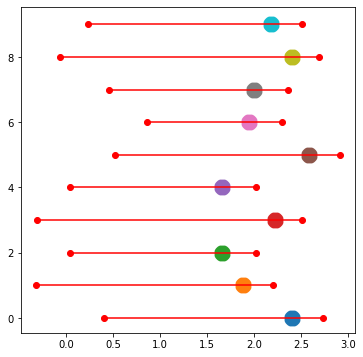

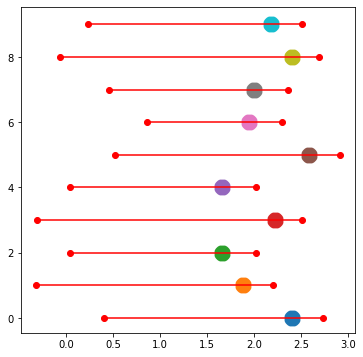

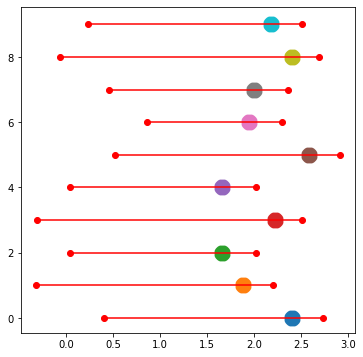

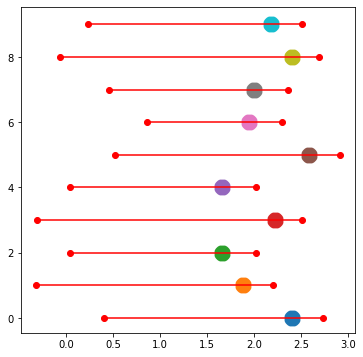

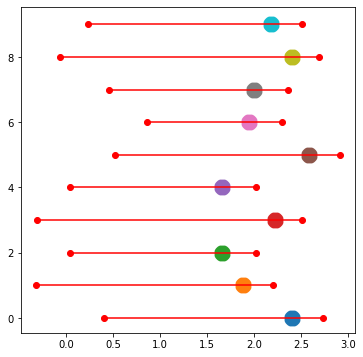

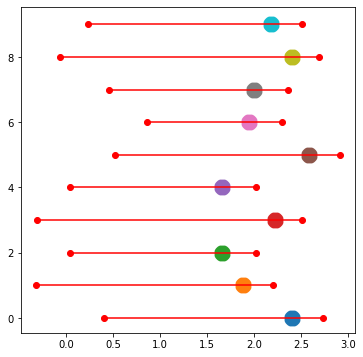

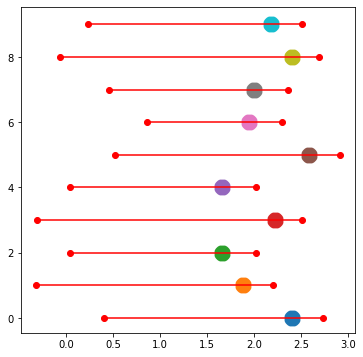

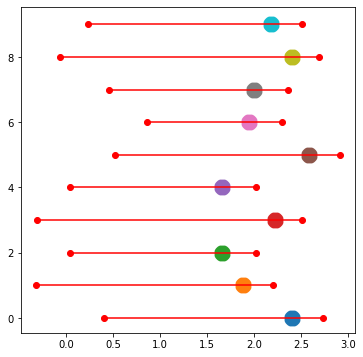

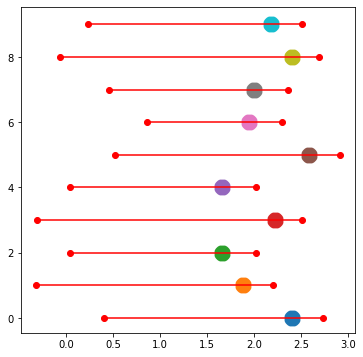

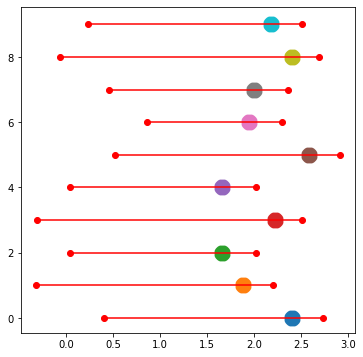

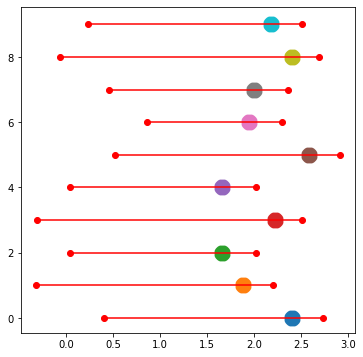

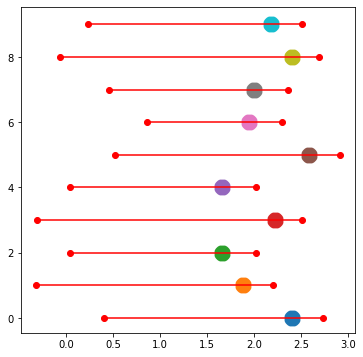

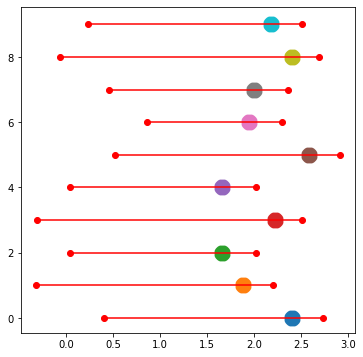

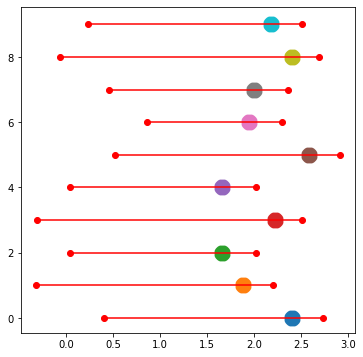

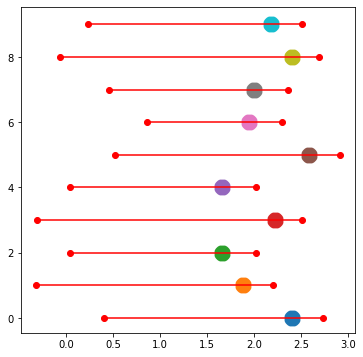

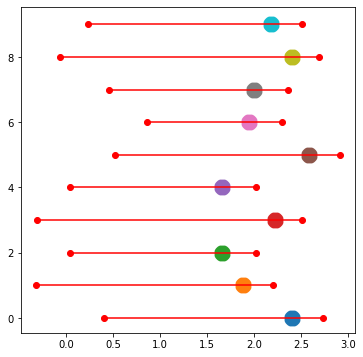

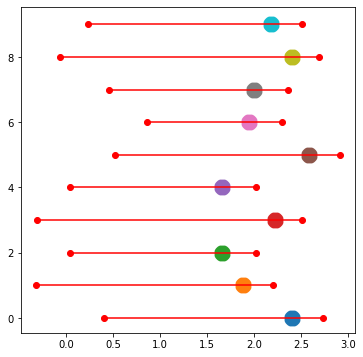

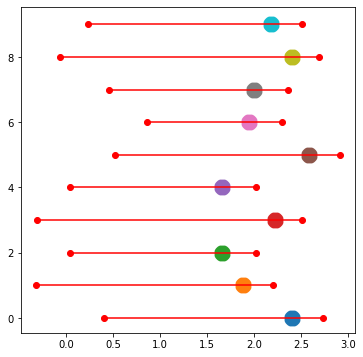

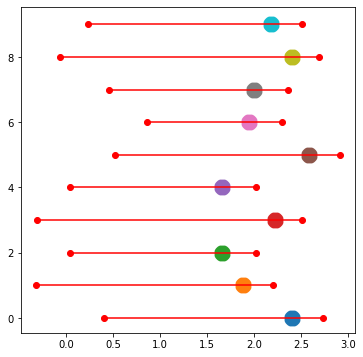

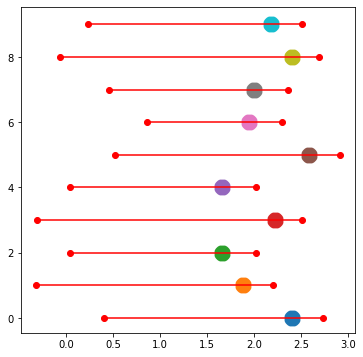

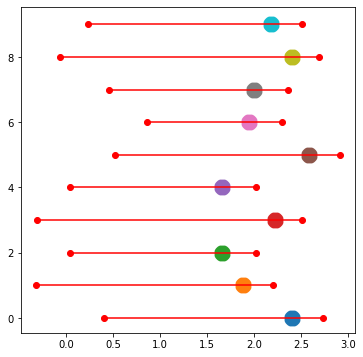

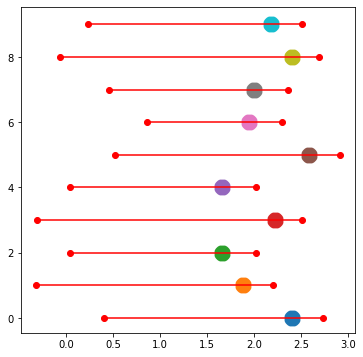

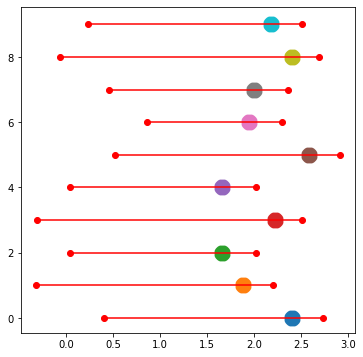

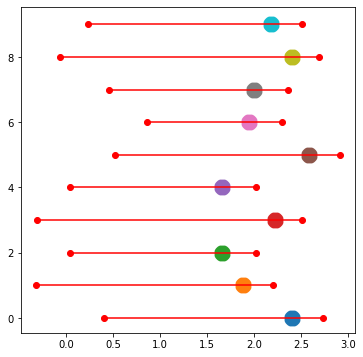

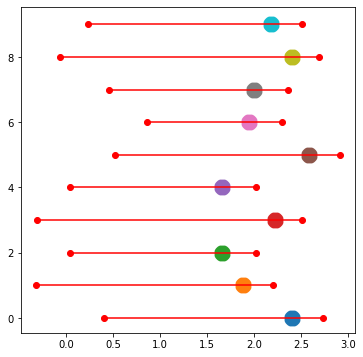

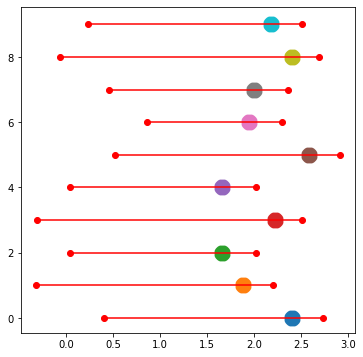

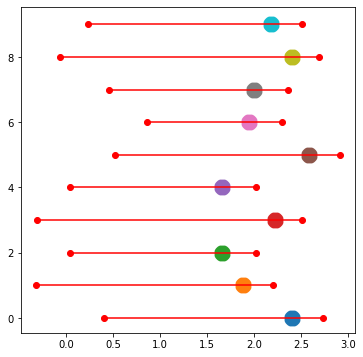

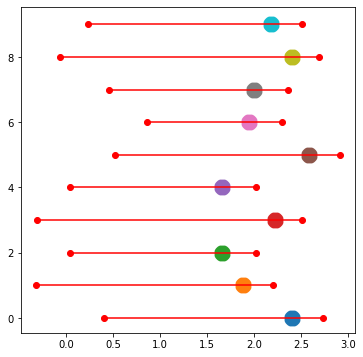

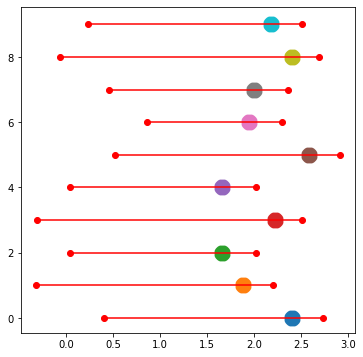

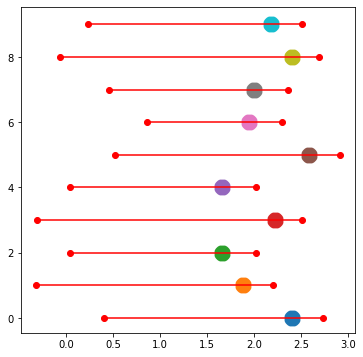

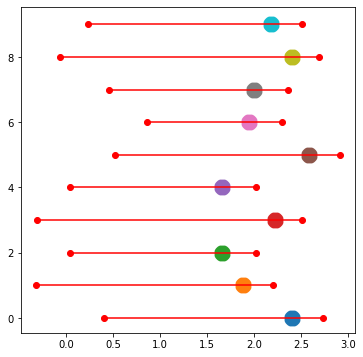

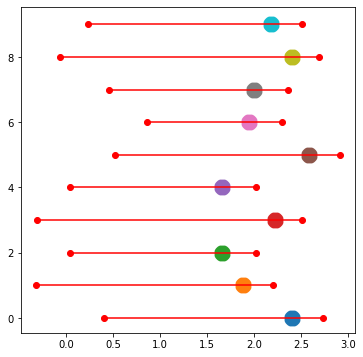

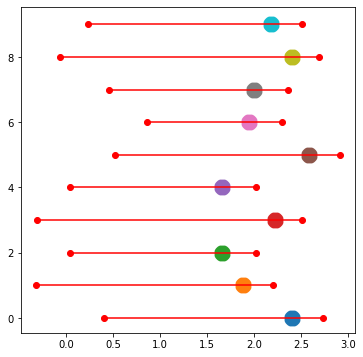

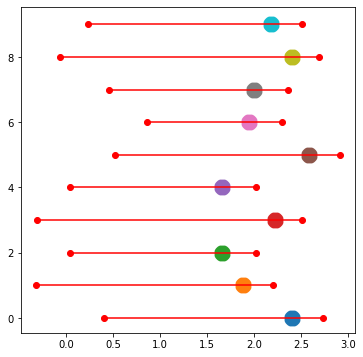

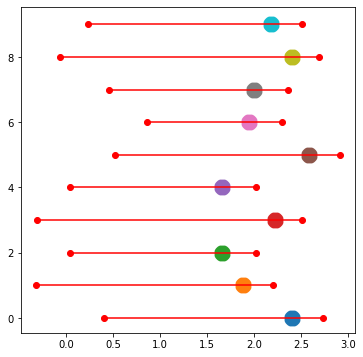

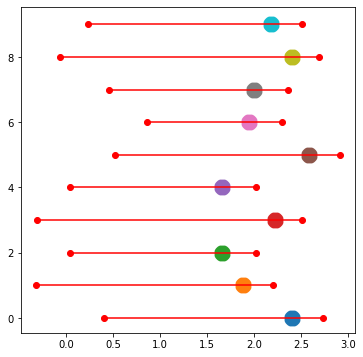

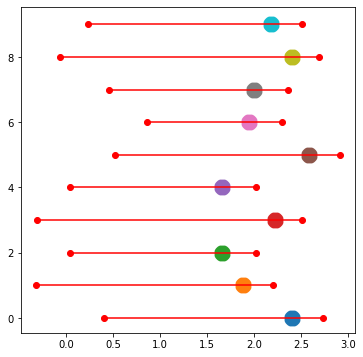

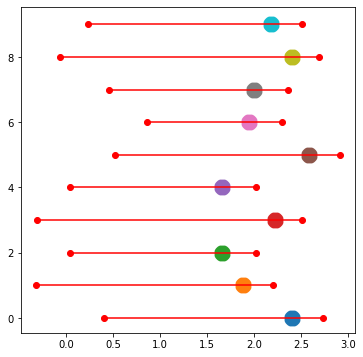

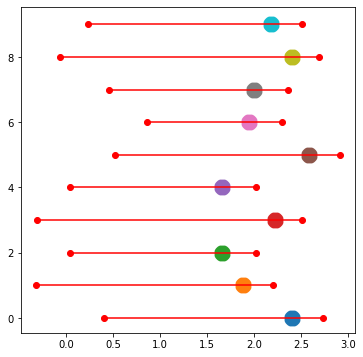

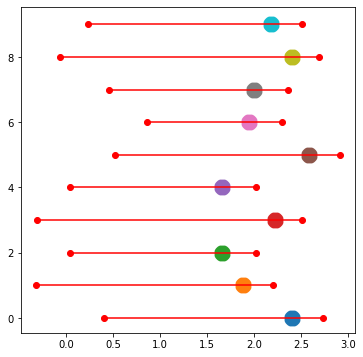

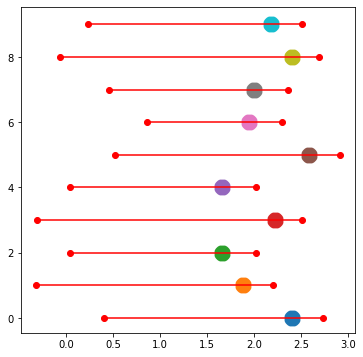

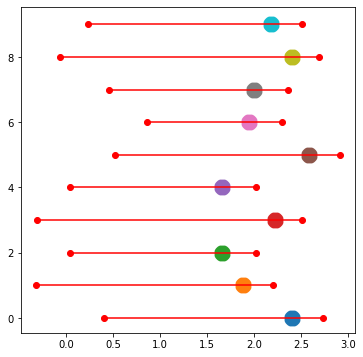

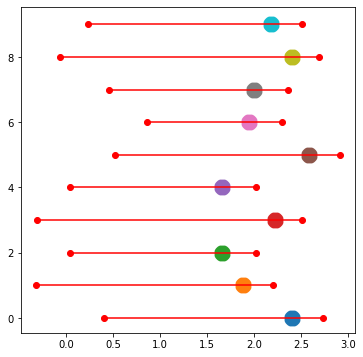

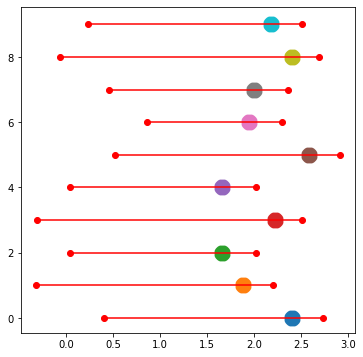

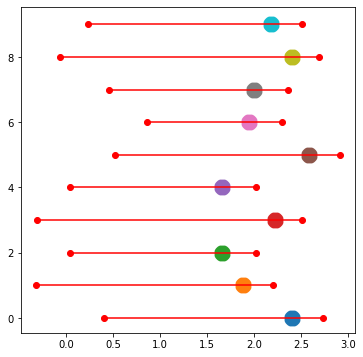

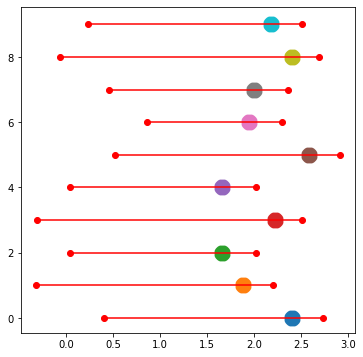

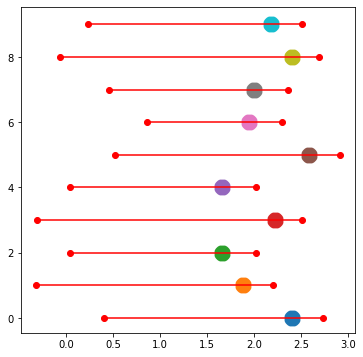

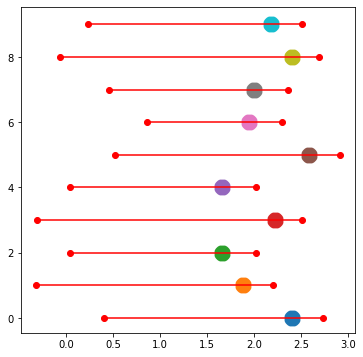

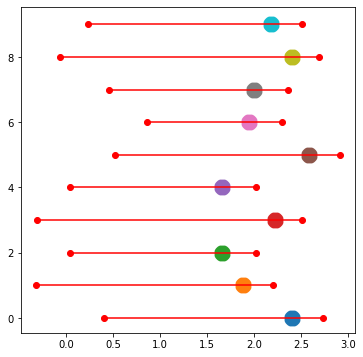

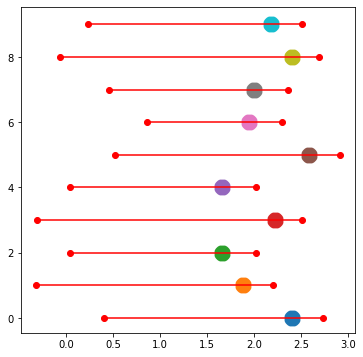

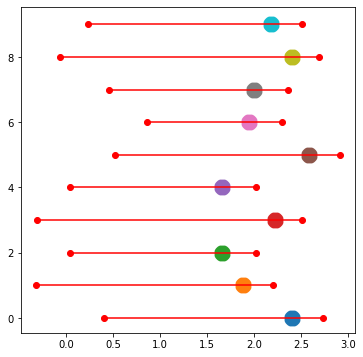

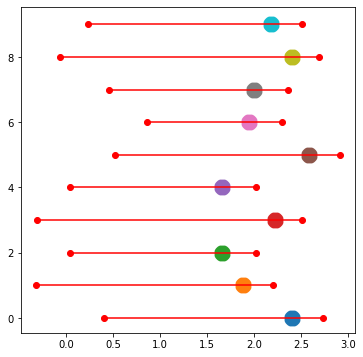

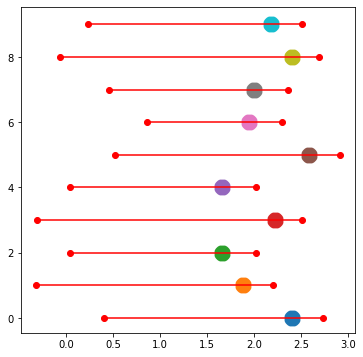

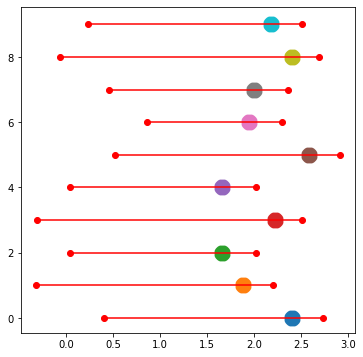

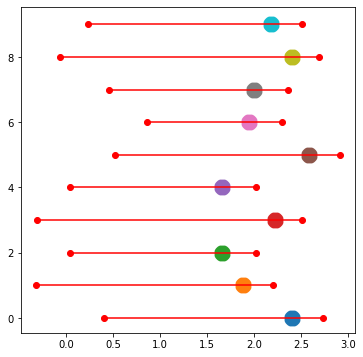

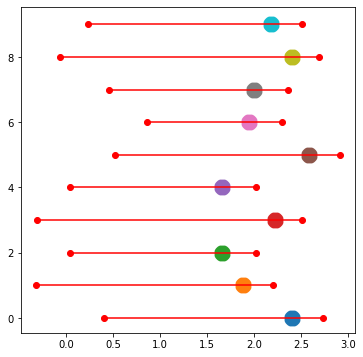

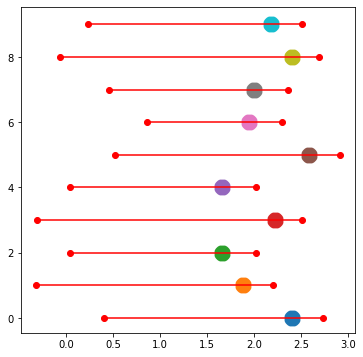

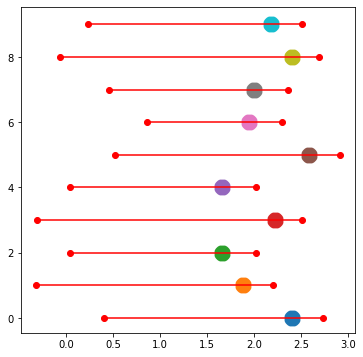

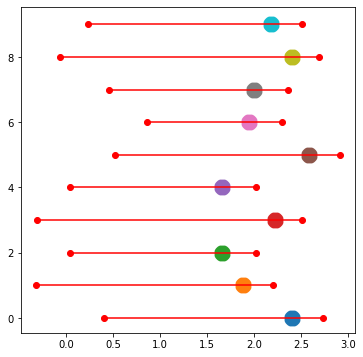

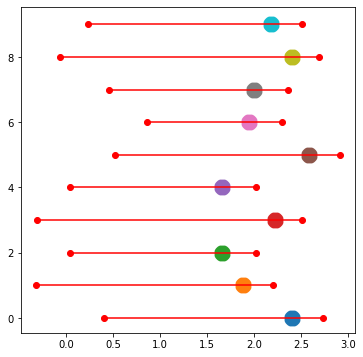

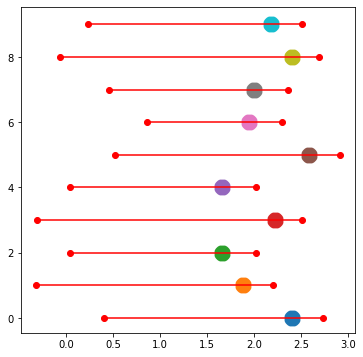

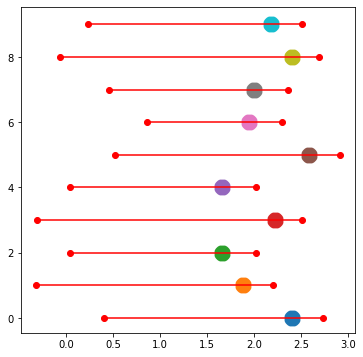

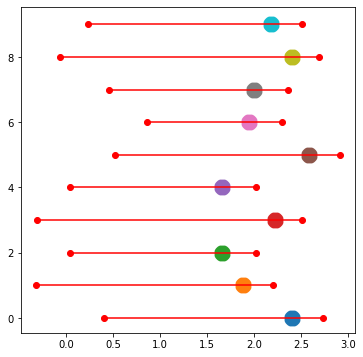

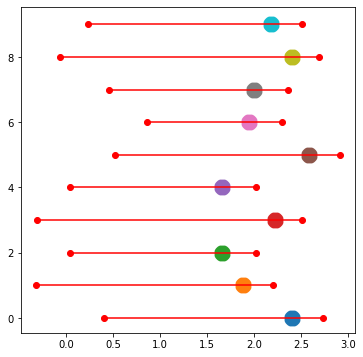

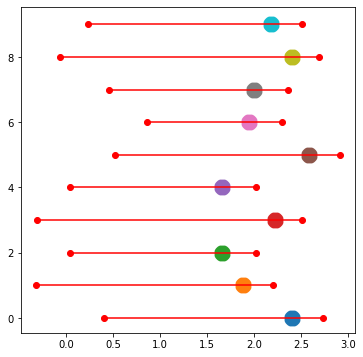

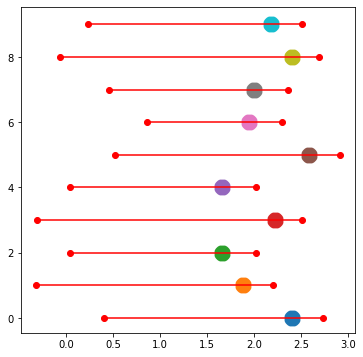

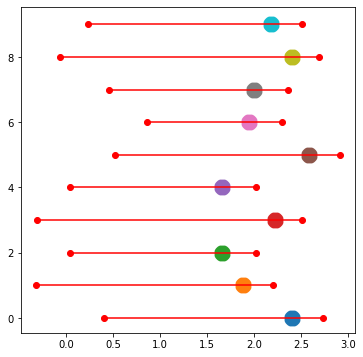

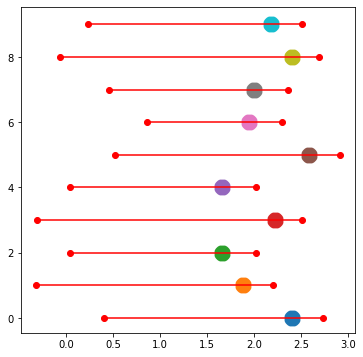

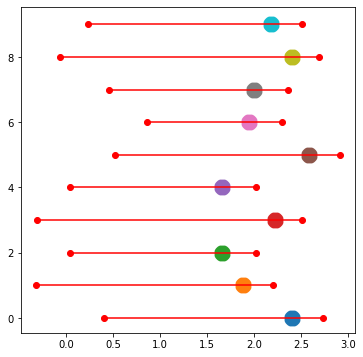

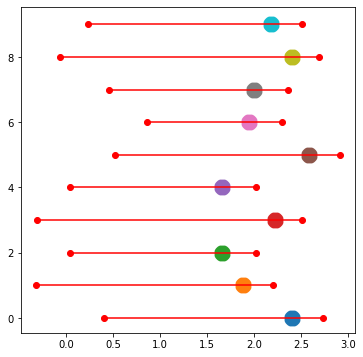

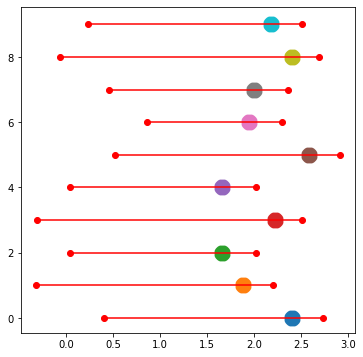

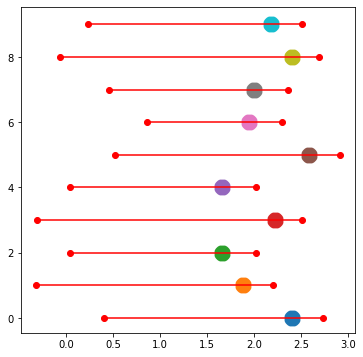

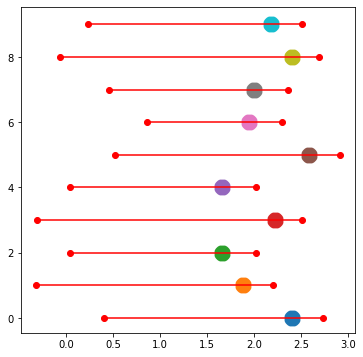

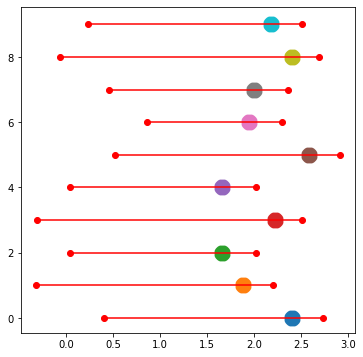

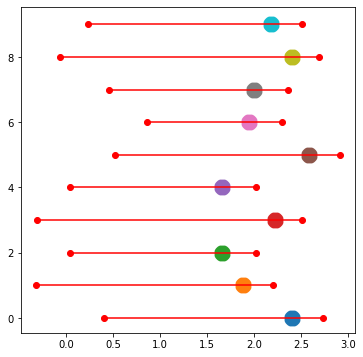

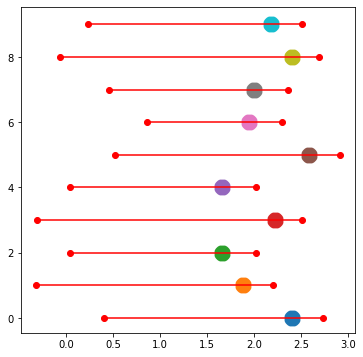

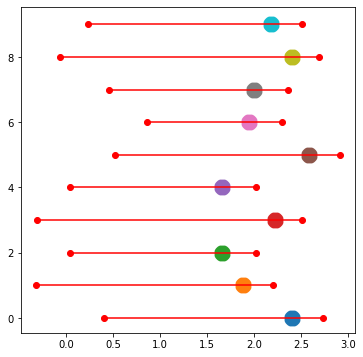

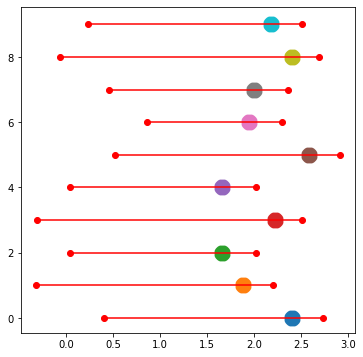

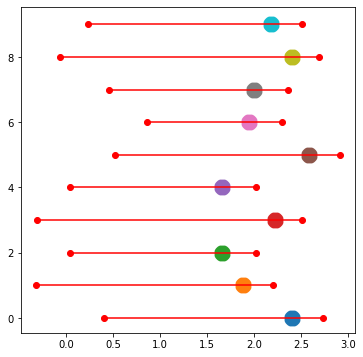

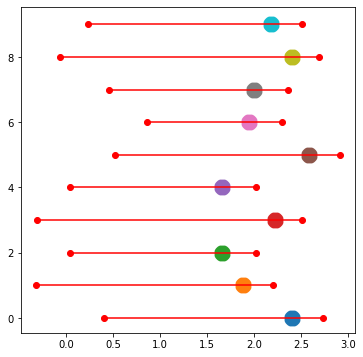

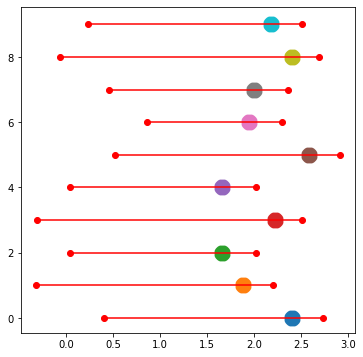

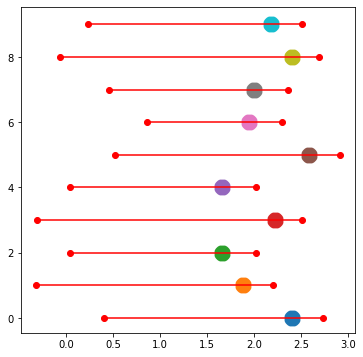

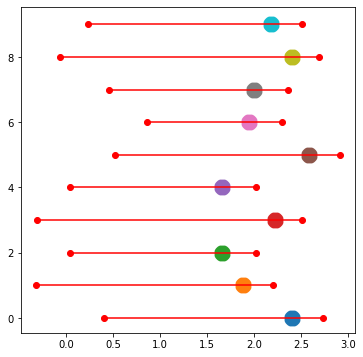

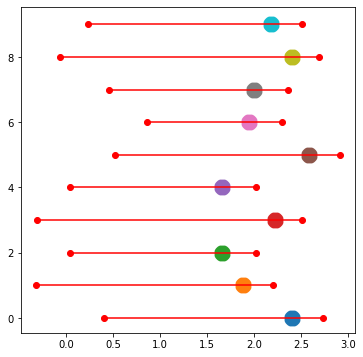

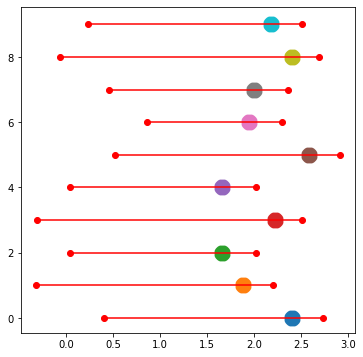

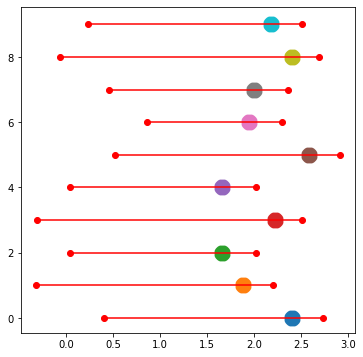

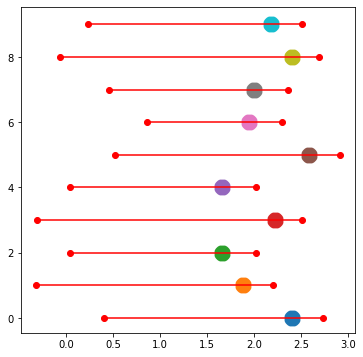

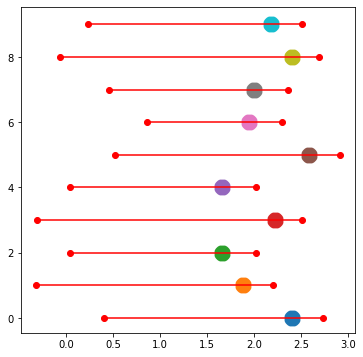

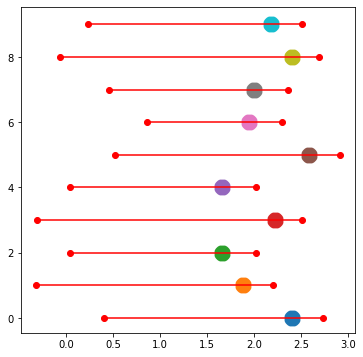

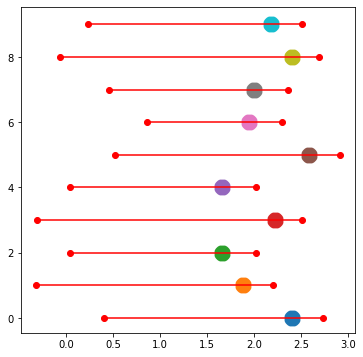

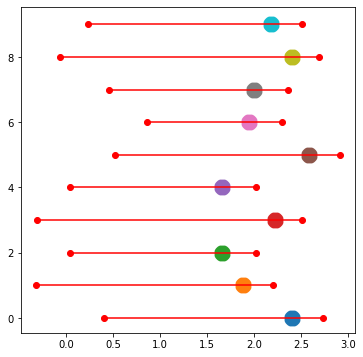

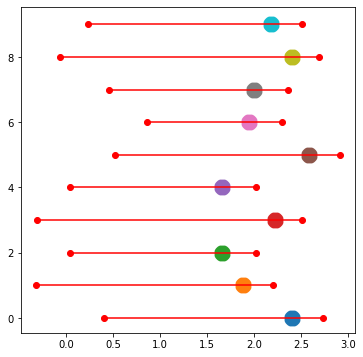

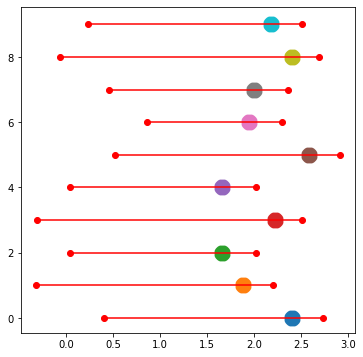

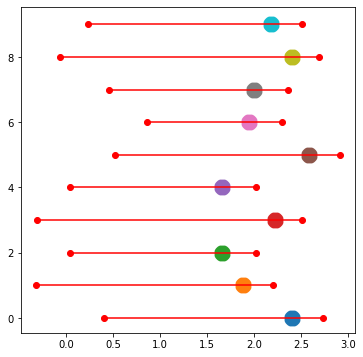

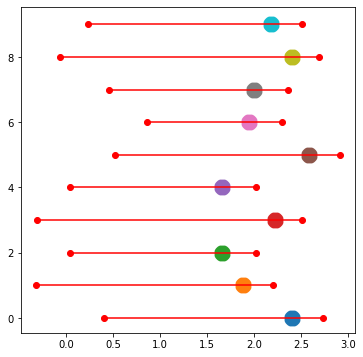

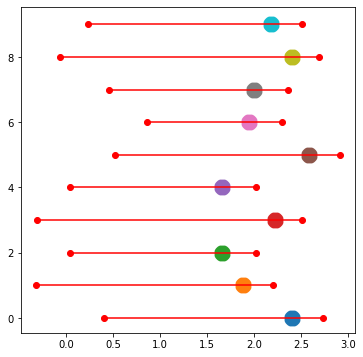

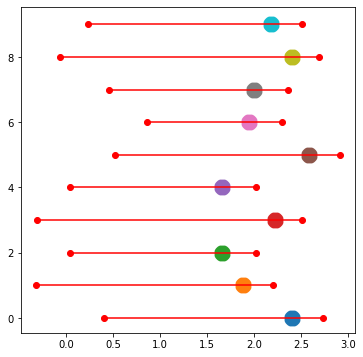

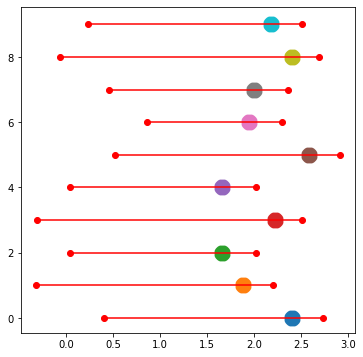

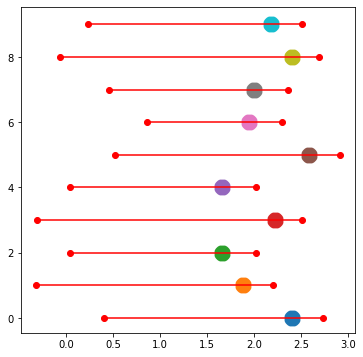

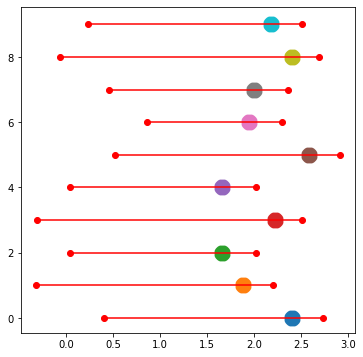

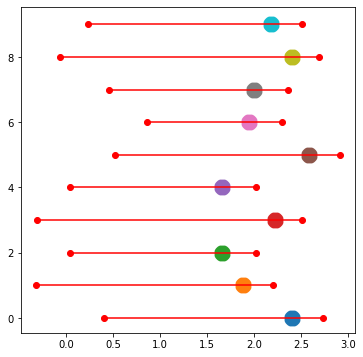

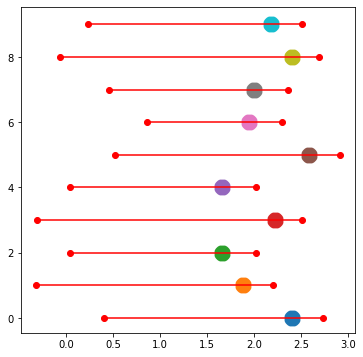

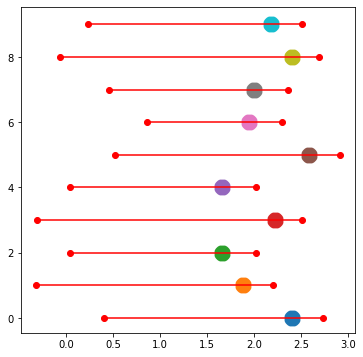

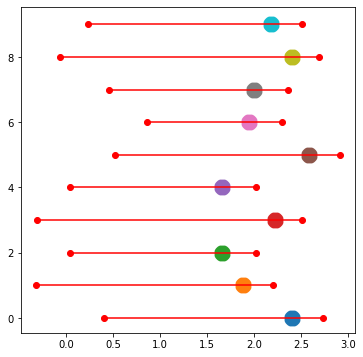

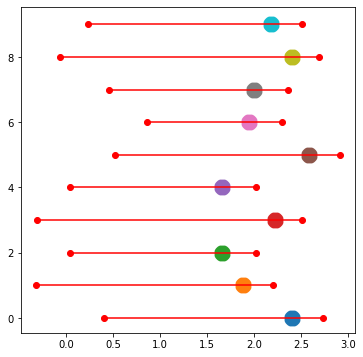

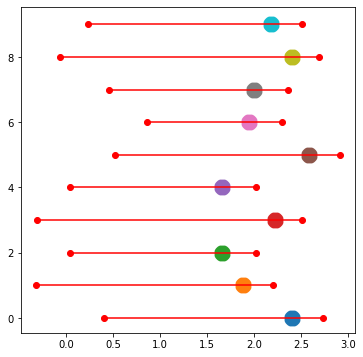

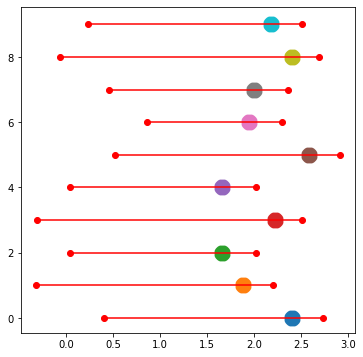

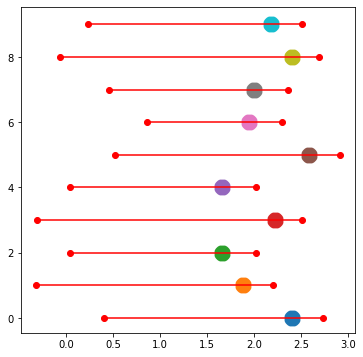

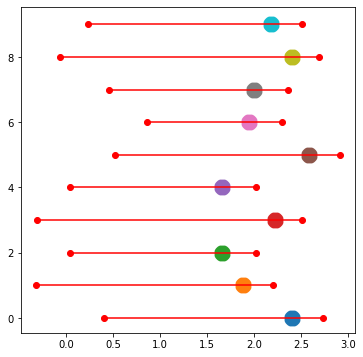

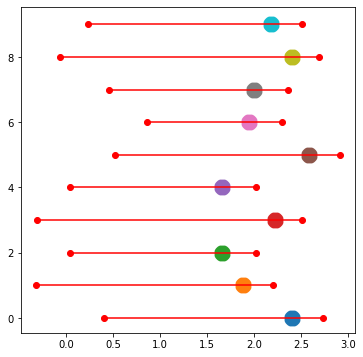

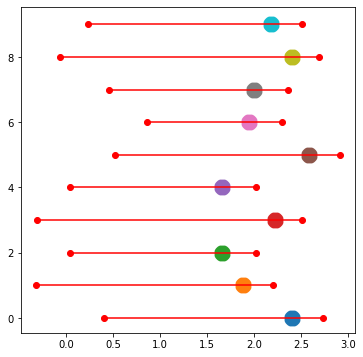

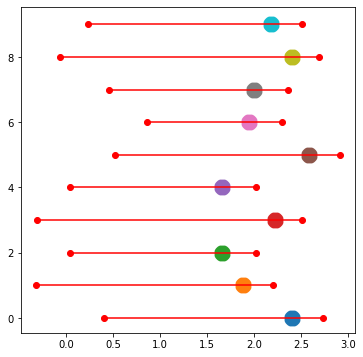

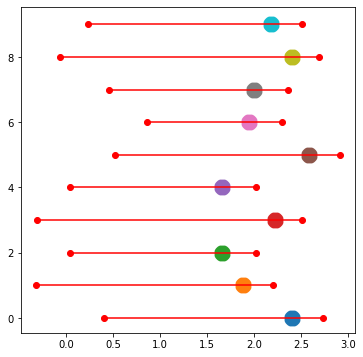

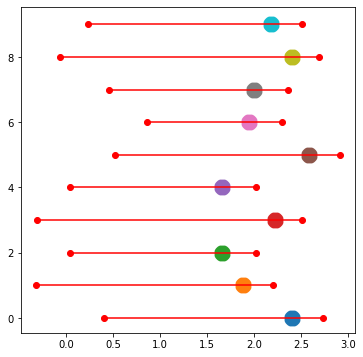

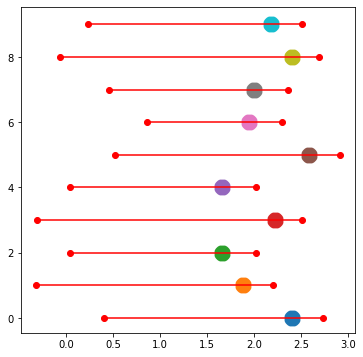

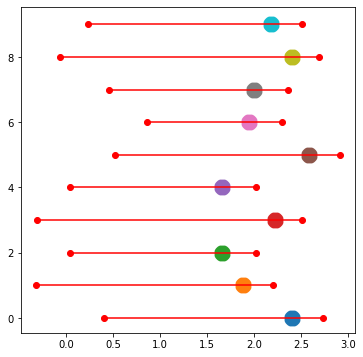

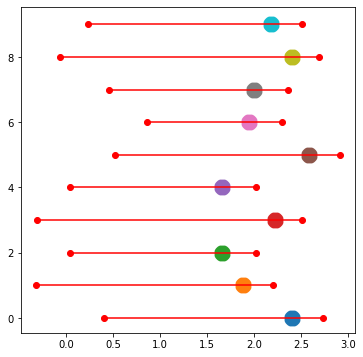

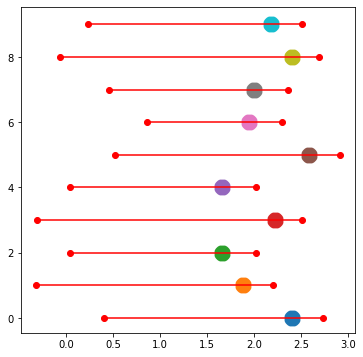

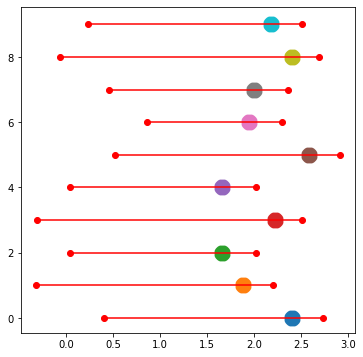

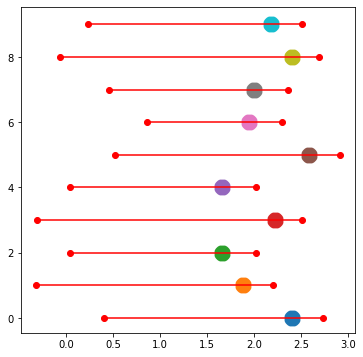

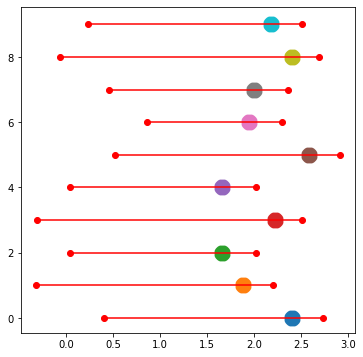

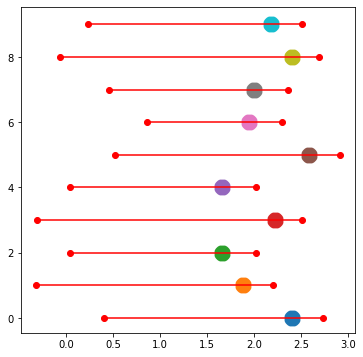

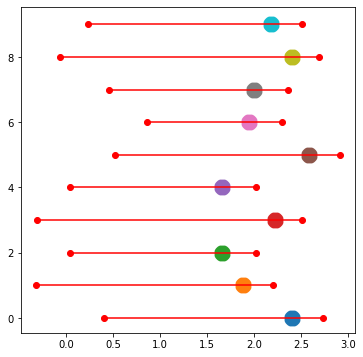

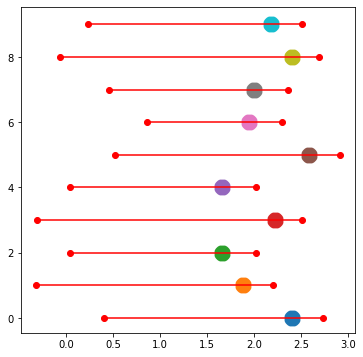

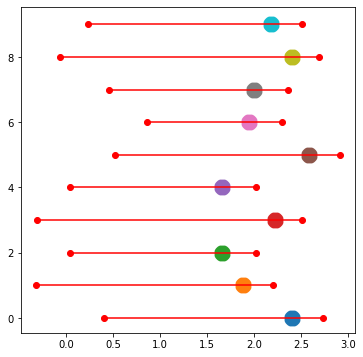

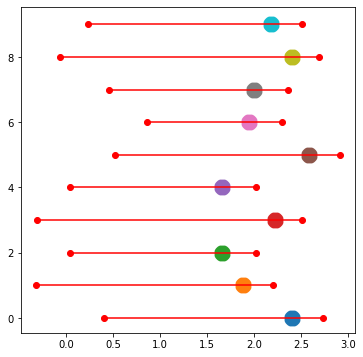

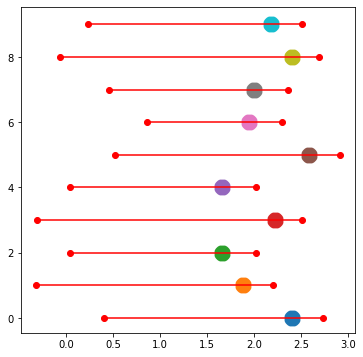

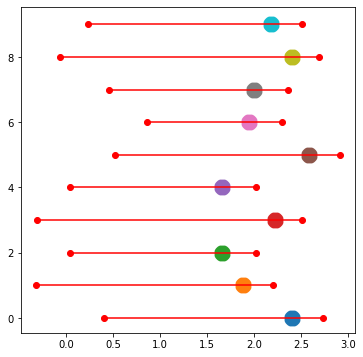

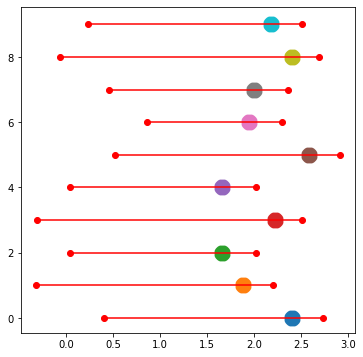

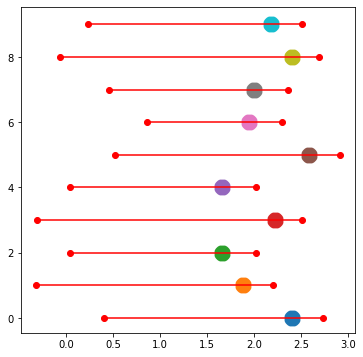

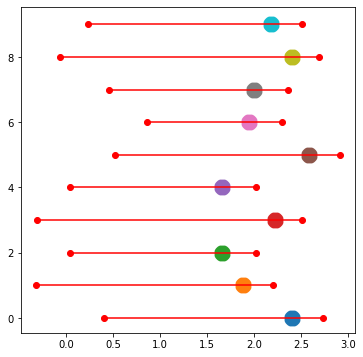

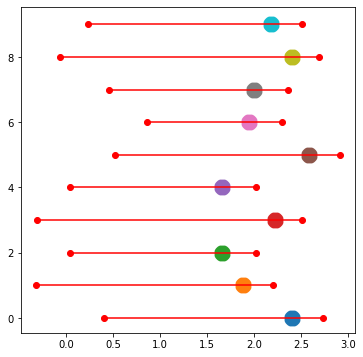

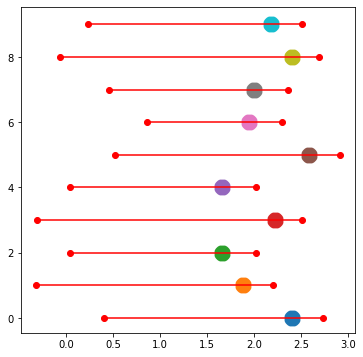

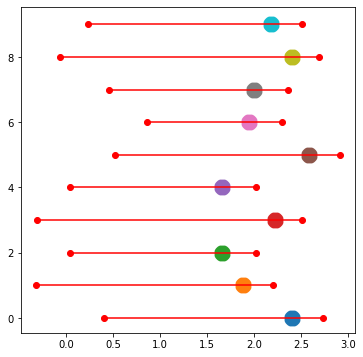

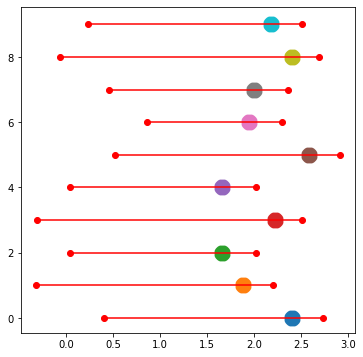

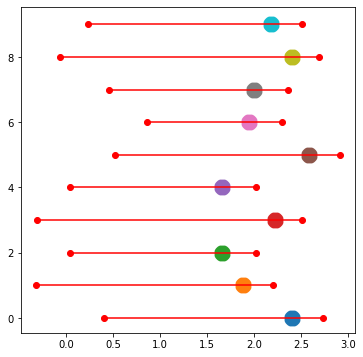

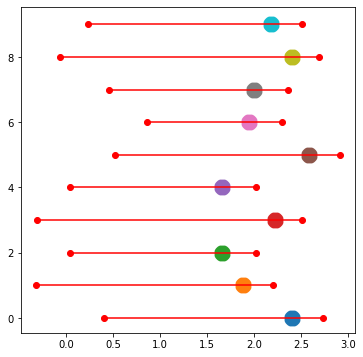

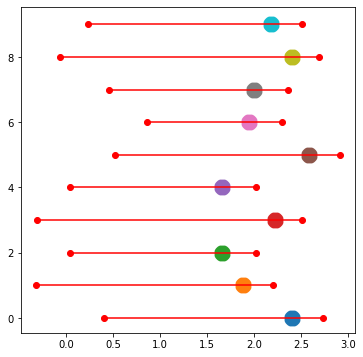

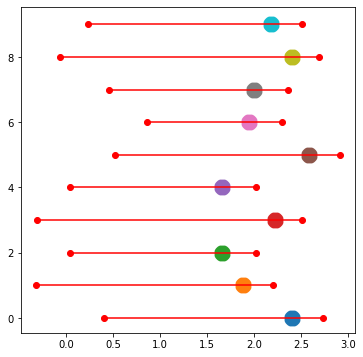

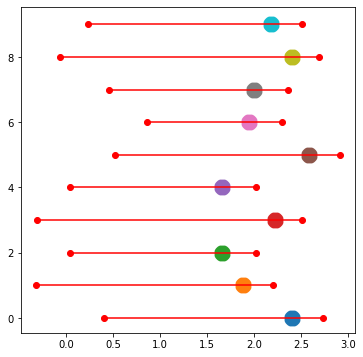

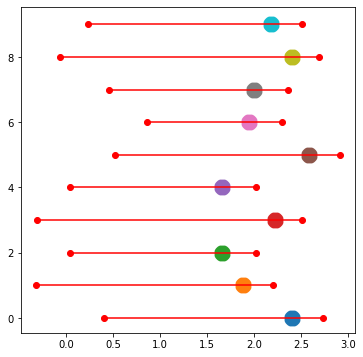

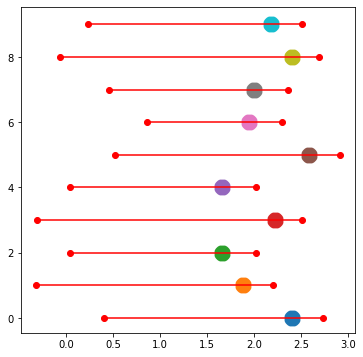

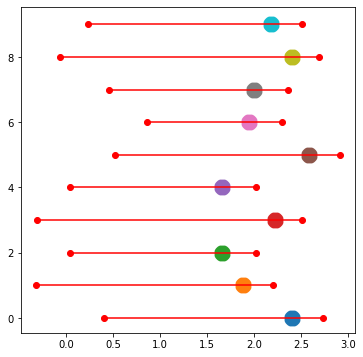

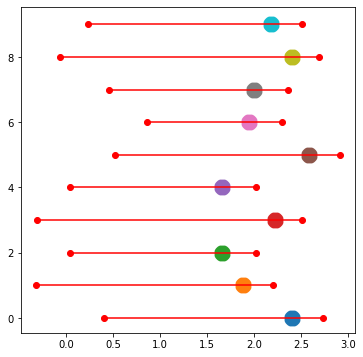

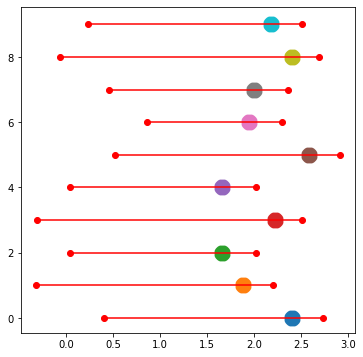

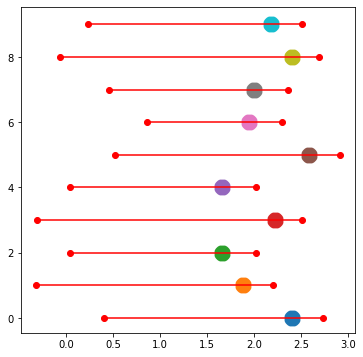

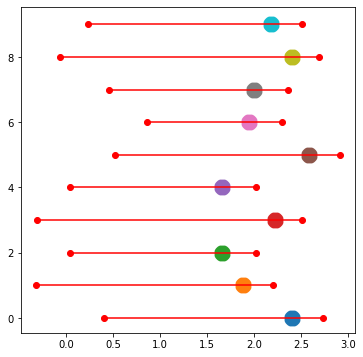

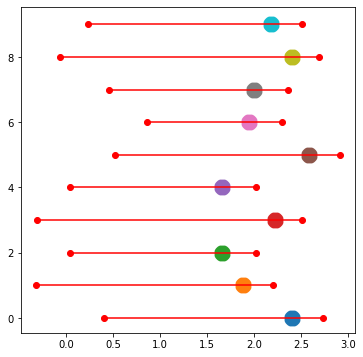

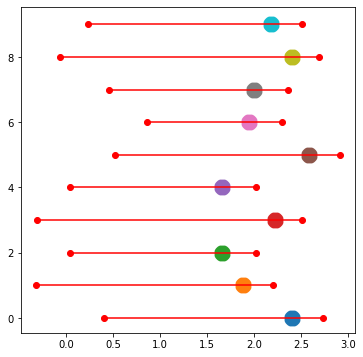

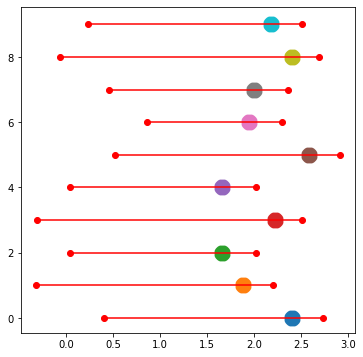

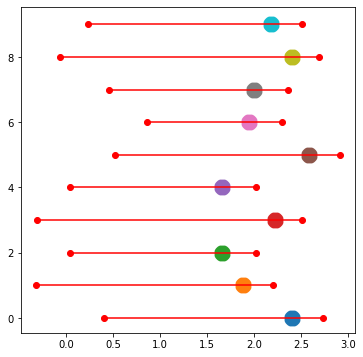

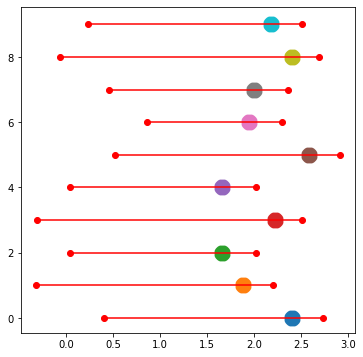

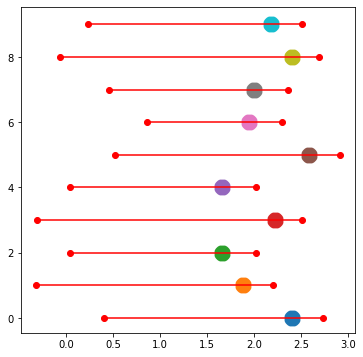

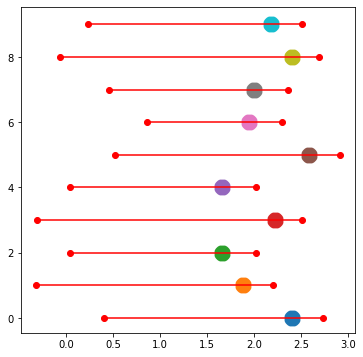

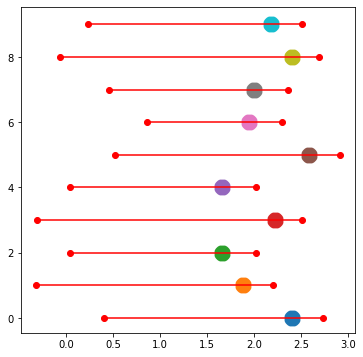

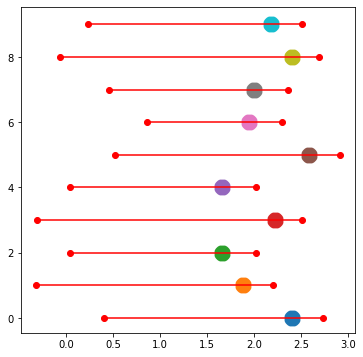

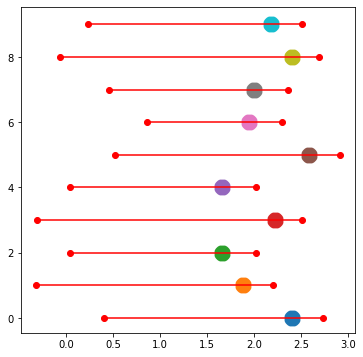

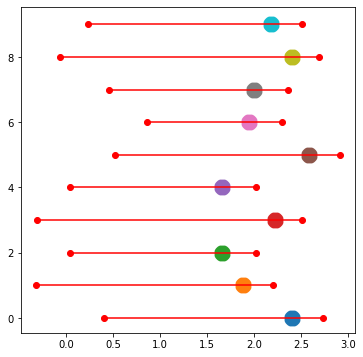

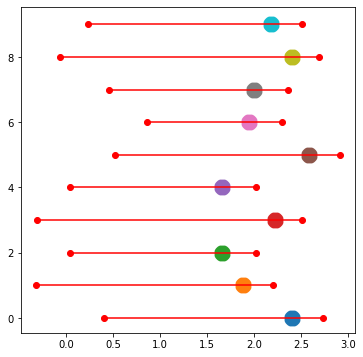

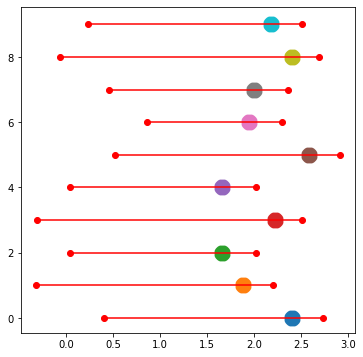

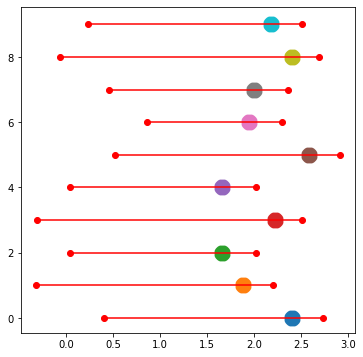

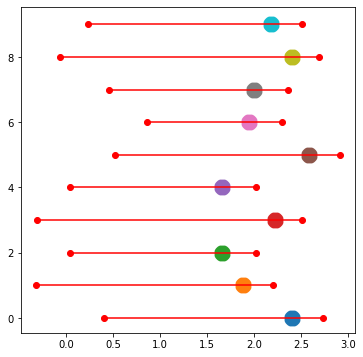

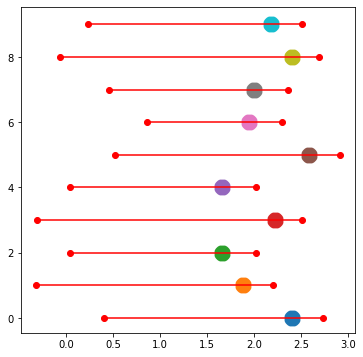

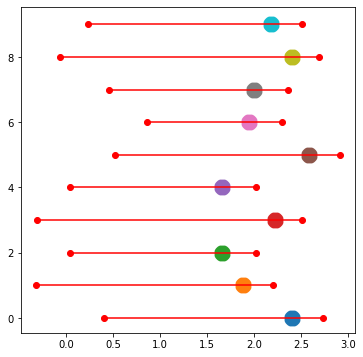

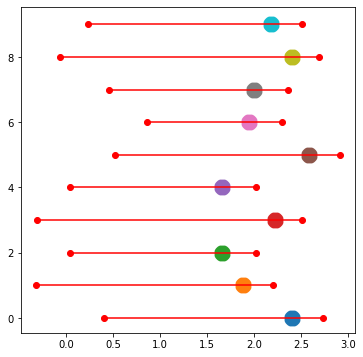

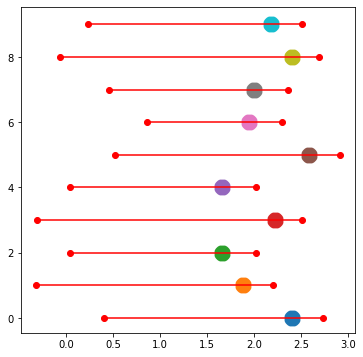

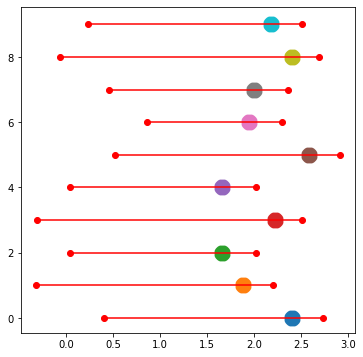

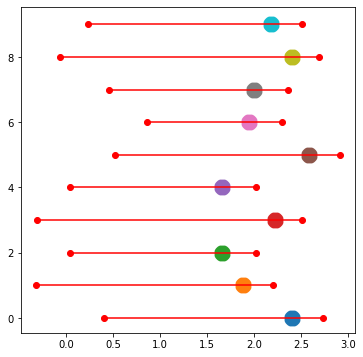

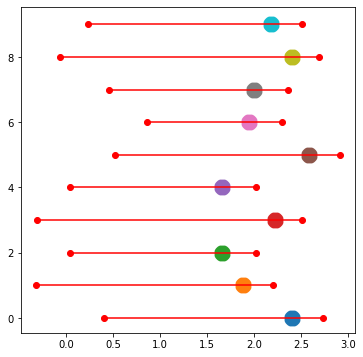

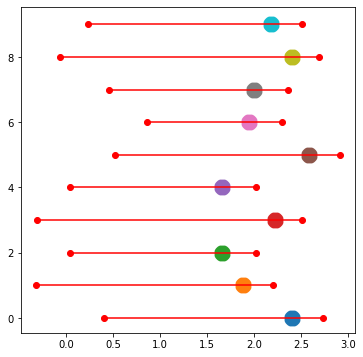

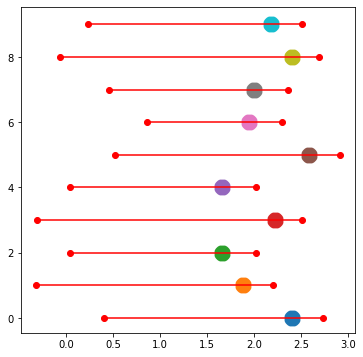

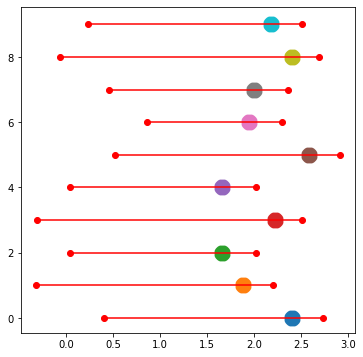

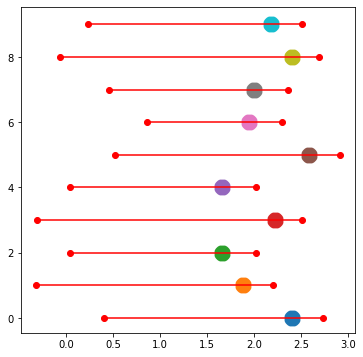

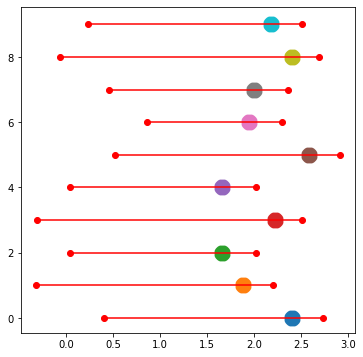

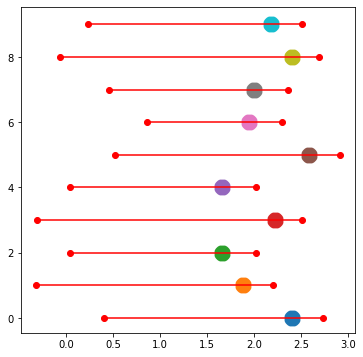

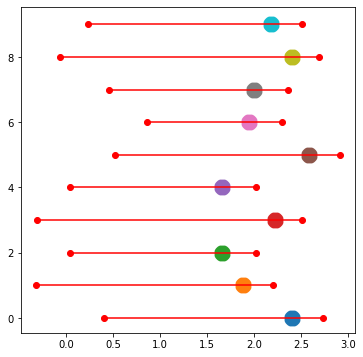

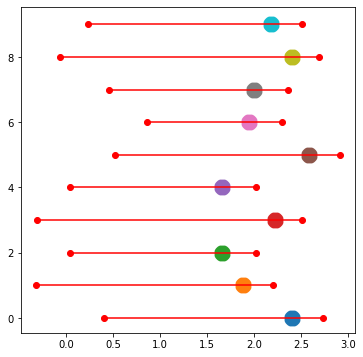

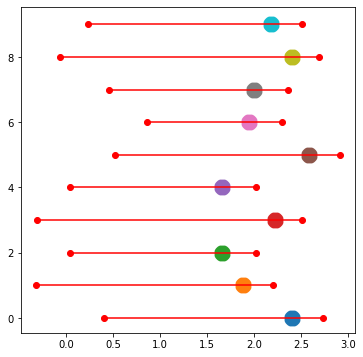

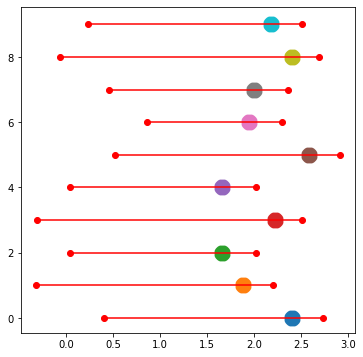

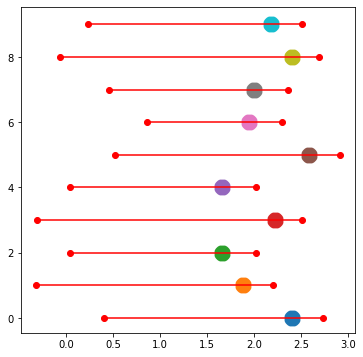

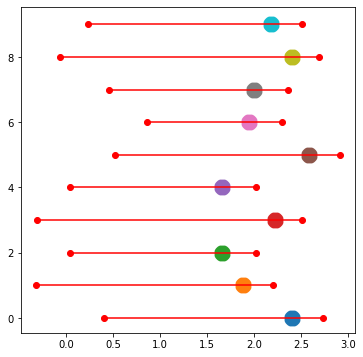

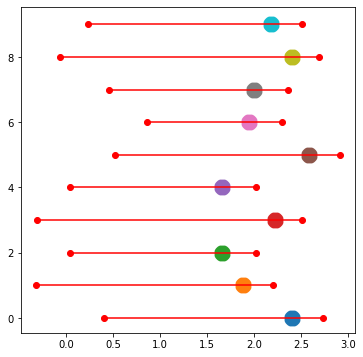

In [27]:
criterion = nn.CrossEntropyLoss()
optimizer_where = optim.SGD(where.parameters(), lr=0.01, momentum=0.9)
optimizer_what = optim.SGD(what.parameters(), lr=0.01, momentum=0.9)

nos_epochs = 250

train_loss=[]

train_acc = [] 
ig = np.random.randint(0,250)
for epoch in range(nos_epochs):  # loop over the dataset multiple times
    
    running_loss = 0.0
    running_acc = 0
    cnt=0
    c = 0
    iteration = desired_num // batch
    
    for i, data in  enumerate(train_loader):
        inputs , labels , fore_idx = data
        
        #optimizer_what.zero_grad()
        optimizer_where.zero_grad()
        
        avg_inp,alphas = where(inputs)
        
        outputs = what(avg_inp)
        
        _, predicted = torch.max(outputs.data, 1)
        
        
        
        
        # display plots 
        #print(inputs[:10])
        
        if(c==0):
            #p = inputs[:10].numpy()
            #print("kkldsksd",p)
            #print("ddasdas",p[:,0])
            disp_plot(inputs[:10,:],avg_inp[:10],1,labels[:10].numpy()
                      ,predicted[:10].numpy(), alphas[:10,:], fore_idx[:10].numpy())
            c+=1
            
        loss = criterion(outputs, labels) 
        loss.backward() 
        
        #optimizer_what.step()
        optimizer_where.step() 
        for w in where.parameters():
            print("new_weights ",w)

        running_loss += loss.item()
        running_acc+=sum(predicted.cpu().numpy()== labels.cpu().numpy())
        
        if cnt % 4 == 3:    # print every 6 mini-batches
            print('[%d, %5d] loss: %.3f' %(epoch + 1, cnt + 1, running_loss/4 ))
            print('[%d,%5d] accuracy: %.3f' %(epoch + 1, cnt+1,running_acc/1000))
            
            train_loss.append(running_loss)
            train_acc.append(running_acc /1000)
            running_loss = 0.0
            running_acc = 0
            torch.save(where.state_dict(),"weight_fixed_where_elemental/where_model_epoch"+str(epoch)+".pt")
            torch.save(what.state_dict(),"weight_fixed_where_elemental/what_model_epoch"+str(epoch)+".pt")
        cnt=cnt+1
        
print('Finished Training')
torch.save(where.state_dict(),"weight_fixed_where_elemental/where_model_epoch"+str(nos_epochs)+".pt")
torch.save(what.state_dict(),"weight_fixed_where_elemental/what_model_epoch"+str(epoch)+".pt") 